In [273]:
import pandas as pd
file_path = 'Final_Dataset/Final_dataset_20_21.xlsx'
Final_dataset_20_21 = pd.read_excel(file_path)
file_path2 = 'Final_Dataset/Final_dataset_21_22.xlsx'
Final_dataset_21_22 = pd.read_excel(file_path2)
file_path3 = 'Final_Dataset/Final_dataset_22_23.xlsx'
Final_dataset_22_23 = pd.read_excel(file_path3)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
data = pd.concat([Final_dataset_20_21, Final_dataset_21_22, Final_dataset_22_23], ignore_index=True)
data.to_excel("Final_Dataset.xlsx")

In [274]:
fill_value_dict = {'Promoted_from_20_21_home': 0,
                   'Promoted_from_20_21_away': 0,
                   'Promoted_from_21_22_home': 0,
                   'Promoted_from_21_22_away': 0,
                   'Promoted_from_19_20_home': 0,
                   'Promoted_from_19_20_away': 0,

                   }
data = data.fillna(fill_value_dict)


In [275]:
data.columns

Index(['Unnamed: 0', 'Team', 'Match', 'Match Date', 'Total Distance Covered',
       'Distance Covered Speed 0-0.2 m/s', 'Distance Covered Speed 0.21-2 m/s',
       'Distance Covered Speed 2.01-4 m/s',
       'Distance Covered Speed 4.01-5.5 m/s',
       'Distance Covered Speed 5.51-7 m/s', 'Distance Covered Speed >7 m/s',
       'No. of Accelerations 5.5-7 m/s²', 'No. of Accelerations >7 m/s²',
       'Maximal Speed', 'Home Team', 'Home Score', 'Away Team', 'Away Score',
       'Cumulative Points', 'Cumulative Goal Difference',
       'Cumulative Goals Scored', 'Cumulative Goals Conceded',
       'Cumulative Wins', 'Cumulative Losses', 'Cumulative Ties',
       'Current Form Points', 'Current Form Goal Difference',
       'Current Form Goals Scored', 'Current Form Goals Conceded',
       'Current Form Wins', 'Current Form Losses', 'Current Form Ties',
       'High Speed Runs Attacking', 'High Speed Runs Defensive',
       'Sprints Attacking', 'Sprints Defensive', 'Home/Away', 'Goals S

In [285]:
import re
df = data
df[['Home Team', 'Away Team']] = df['Match'].str.extract(r'(\w+.*?)\s\d+[:]\d+\s(\w+.*?)')
# Identify if the current row team is Home or Away and add the other team's data
df['Opponent'] = df.apply(lambda row: row['Away Team'] if row['Team'] == row['Home Team'] else row['Home Team'], axis=1)

# Drop intermediate columns used for extraction
df = df.drop(columns=['Home Team', 'Away Team'])
unique_opponents = df['Opponent'].unique()
unique_opponents

array(['Fenerbahce', 'Kasimpasa', 'Alanyaspor', 'Kayserispor',
       'Hatayspor', 'Galatasaray', 'Trabzonspor', 'Antalyaspor',
       'Konyaspor', 'Besiktas', 'Yeni Malatyaspor', 'Gaziantep', 'BB',
       'Yeni', 'Gaziantep FK', 'Rizespor', 'Fatih', 'Goztepe',
       'Genclerbirligi', 'Istanbul', 'Erzurumspor', 'Ankaragucu',
       'Sivasspor', 'Fatih Karagumruk', 'Denizlispor',
       'Istanbul Basaksehir', 'BB Erzurumspor', 'Adana', 'Altay SK',
       'Giresunspor', 'Adana Demirspor', 'Altay', 'Galatasaray A.S.',
       'Istanbul Basaksehir FK', 'Istanbulspor', 'Umraniyespor'],
      dtype=object)

In [286]:
def remove_duplicate_words(opponent_name):
  """Removes duplicate words within an opponent name."""
  return re.sub(r"\b(\w+)( \1\b)+", r"\1", opponent_name)

def correct_opponent_names(opponent_name):
    # Replacements for inconsistent names
    replacements = {
        "Yeni": "Yeni Malatyaspor",
        "Fatih": "Fatih Karagumruk",
        "Istanbul Basaksehir FK": "Istanbul Basaksehir",
        "Istanbul":"Istanbul Basaksehir",
        "BB": "BB Erzurumspor",
        "Galatasaray A.S.": "Galatasaray",
        "Gaziantep":"Gaziantep FK",
        "Erzurumspor": "BB Erzurumspor", 
        "Adana":"Adana Demirspor",
        "Altay": "Altay SK"
    }
    for pattern, replacement in replacements.items():
        opponent_name = re.sub(pattern, replacement, opponent_name, count=1)

        opponent_name = remove_duplicate_words(opponent_name)
    return opponent_name

# Apply the correction function to the 'Opponent' column
df['Opponent'] = df['Opponent'].apply(correct_opponent_names)
df['Team'] = df['Team'].apply(correct_opponent_names)

In [288]:
def rename_opponent_columns(df):
    columns_to_rename = [
        'Total Distance Covered', 'Distance Covered Speed 0-0.2 m/s', 'Distance Covered Speed 0.21-2 m/s',
        'Distance Covered Speed 2.01-4 m/s', 'Distance Covered Speed 4.01-5.5 m/s',
        'Distance Covered Speed 5.51-7 m/s', 'Distance Covered Speed >7 m/s',
        'No. of Accelerations 5.5-7 m/s²', 'No. of Accelerations >7 m/s²', 'Maximal Speed',
        'Cumulative Points', 'Cumulative Goal Difference', 'Cumulative Goals Scored',
        'Cumulative Goals Conceded', 'Cumulative Wins', 'Cumulative Losses', 'Cumulative Ties',
        'High Speed Runs Attacking', 'High Speed Runs Defensive', 'Sprints Attacking',
        'Sprints Defensive', 'Home/Away', 'Goal Difference', 'Result','Minutes on the field total attacking','Minutes on the field total defending','Min ball in play'
    ]

    # Create a mapping for renaming
    rename_mapping = {col: f"{col}_opponent" for col in columns_to_rename}

    return rename_mapping
def merge_opponent_data(df):
    # Extract the necessary columns
    rename_mapping = rename_opponent_columns(df)
    opponent_columns = ['Match', 'Team'] + list(rename_mapping.keys())
    
    # Rename the columns for merging
    opponent_df = df[opponent_columns].rename(columns=rename_mapping)
    
    # Adjust the merge to use the correct columns
    merged_df = df.merge(opponent_df, left_on=['Match', 'Opponent'], right_on=['Match', 'Team'], how='left', suffixes=('', '_opponent'))
    
    # Drop the extra opponent team column used for merging
    merged_df = merged_df.drop(columns=['Team_opponent'])
    
    return merged_df

# Apply the merging function to the dataframe
merged_df = merge_opponent_data(df)

# Display the updateddataframe to the user
merged_df

Unnamed: 0       Team                                 Match Match Date  \
0              0   Rizespor               Rizespor 1:2 Fenerbahce   11.09.20   
1              1   Rizespor                Kasimpasa 2:0 Rizespor   20.09.20   
2              2   Rizespor               Rizespor 1:1 Alanyaspor   27.09.20   
3              3   Rizespor              Rizespor 1:0 Kayserispor   01.11.20   
4              3   Rizespor              Rizespor 1:0 Kayserispor   01.11.20   
...          ...        ...                                   ...        ...   
1769         281  Hatayspor        Fatih Karagumruk 3:0 Hatayspor   15.10.22   
1770         282  Hatayspor                Hatayspor 2:1 Besiktas   24.10.22   
1771         283  Hatayspor              Ankaragucu 4:1 Hatayspor   30.10.22   
1772         284  Hatayspor  Hatayspor 3:3 Istanbul Basaksehir FK   07.11.22   
1773         285  Hatayspor            Istanbulspor 0:1 Hatayspor   13.11.22   

      Total Distance Covered  Distance Covered Speed 0-0.2 m/s  \
0                     111784                               279   
1                     114153                               276   
2                     109381                               355   
3                     110355                               232   
4                     110355                               232   
...                      ...                               ...   
1769                  116160                               395   
1770                  116511                               305   
1771                  111934                               353   
1772                  117921                               324   
1773                  115460                               342   

      Distance Covered Speed 0.21-2 m/s  Distance Covered Speed 2.01-4 m/s  \
0                                 42168                              43537   
1                                 39961                              44998   
2                                 42605                              41928   
3                                 43845                              44061   
4                                 43845                              44061   
...                                 ...                                ...   
1769                              38742                              45339   
1770                              41356                              45881   
1771                              38498                              44120   
1772                              40774                              46125   
1773                              38807                              44173   

      Distance Covered Speed 4.01-5.5 m/s  Distance Covered Speed 5.51-7 m/s  \
0                                   16792                               7481   
1                                   19583                               7853   
2                                   16425                               6991   
3                                   15360                               5918   
4                                   15360                               5918   
...                                   ...                                ...   
1769                                20975                               8791   
1770                                18805                               8039   
1771                                18954                               7735   
1772                                21052                               7444   
1773                                20359                               9636   

      ...  High Speed Runs Attacking_opponent  \
0     ...                              346.00   
1     ...                              345.00   
2     ...                              320.00   
3     ...                              259.00   
4     ...                              287.00   
...   ...                                 ...   
1769  ...  

Every row has all the metrics we need to predict the match outcome

In [289]:
merged_df = merged_df.drop(columns=['Unnamed: 0'])

# Rename 'Team' to 'Home_team'
merged_df = merged_df.rename(columns={'Team': 'Home_team'})

# Columns to append '_Home'
columns_to_append_home = [
    'Total Distance Covered',
    'Distance Covered Speed 0-0.2 m/s', 'Distance Covered Speed 0.21-2 m/s',
    'Distance Covered Speed 2.01-4 m/s', 'Distance Covered Speed 4.01-5.5 m/s',
    'Distance Covered Speed 5.51-7 m/s', 'Distance Covered Speed >7 m/s',
    'No. of Accelerations 5.5-7 m/s²', 'No. of Accelerations >7 m/s²', 'Maximal Speed','Cumulative Points',
    'Cumulative Goal Difference', 'Cumulative Goals Scored',
    'Cumulative Goals Conceded', 'Cumulative Wins', 'Cumulative Losses',
    'Cumulative Ties', 'Current Form Points', 'Current Form Goal Difference',
    'Current Form Goals Scored', 'Current Form Goals Conceded',
    'Current Form Wins', 'Current Form Losses', 'Current Form Ties',
    'High Speed Runs Attacking', 'High Speed Runs Defensive',
    'Sprints Attacking', 'Sprints Defensive', 'Goals Scored', 'Goals Conceded',
    'Goal Difference', 'Result',
]

# Append '_Home' to specified columns
merged_df = merged_df.rename(columns={col: col + '_Home' for col in columns_to_append_home})

# Rename 'Home/Away' to 'Home/Away_Home'
merged_df = merged_df.rename(columns={'Home/Away': 'Home/Away_Home'})

In [290]:
merged_df.columns

Index(['Home_team', 'Match', 'Match Date', 'Total Distance Covered_Home',
       'Distance Covered Speed 0-0.2 m/s_Home',
       'Distance Covered Speed 0.21-2 m/s_Home',
       'Distance Covered Speed 2.01-4 m/s_Home',
       'Distance Covered Speed 4.01-5.5 m/s_Home',
       'Distance Covered Speed 5.51-7 m/s_Home',
       'Distance Covered Speed >7 m/s_Home',
       'No. of Accelerations 5.5-7 m/s²_Home',
       'No. of Accelerations >7 m/s²_Home', 'Maximal Speed_Home', 'Home Score',
       'Away Score', 'Cumulative Points_Home',
       'Cumulative Goal Difference_Home', 'Cumulative Goals Scored_Home',
       'Cumulative Goals Conceded_Home', 'Cumulative Wins_Home',
       'Cumulative Losses_Home', 'Cumulative Ties_Home',
       'Current Form Points_Home', 'Current Form Goal Difference_Home',
       'Current Form Goals Scored_Home', 'Current Form Goals Conceded_Home',
       'Current Form Wins_Home', 'Current Form Losses_Home',
       'Current Form Ties_Home', 'High Speed Runs Attac

In [291]:
data_unique = merged_df.drop_duplicates(subset=['Match'], keep='first')
def convert_to_minutes(time_str):
    if pd.isnull(time_str) or time_str == "":
        return None
    # Ensure the time string is in string format
    time_str = str(time_str)
    # Convert to timedelta and then to total seconds, and finally to minutes
    td = pd.to_timedelta(time_str)
    return td.total_seconds() / 60



# Apply the conversion function to your time columns
data_unique['Minutes on the field total attacking'] = data_unique['Minutes on the field total attacking'].apply(convert_to_minutes)
data_unique['Minutes on the field total defending'] = data_unique['Minutes on the field total defending'].apply(convert_to_minutes)
data_unique['Min ball in play'] = data_unique['Min ball in play'].apply(convert_to_minutes)
data_unique['Minutes on the field total attacking_opponent'] = data_unique['Minutes on the field total attacking_opponent'].apply(convert_to_minutes)
data_unique['Minutes on the field total defending_opponent'] = data_unique['Minutes on the field total defending_opponent'].apply(convert_to_minutes)
data_unique['Min ball in play_opponent'] = data_unique['Min ball in play_opponent'].apply(convert_to_minutes)

C:\Users\emanu\AppData\Local\Temp\ipykernel_11704\2881226963.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\emanu\AppData\Local\Temp\ipykernel_11704\2881226963.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\emanu\AppData\Local\Temp\ipykernel_11704\2881226963.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [292]:
data_unique.to_excel("m.xlsx")

In [228]:
print("\nMissing Values:")
data_unique.isnull().sum()


Missing Values:


Home_team                                          0
Match                                              0
Match Date                                         0
Total Distance Covered_Home                        0
Distance Covered Speed 0-0.2 m/s_Home              0
                                                ... 
Goal Difference_opponent                           0
Result_opponent                                    0
Minutes on the field total attacking_opponent    336
Minutes on the field total defending_opponent    336
Min ball in play_opponent                        336
Length: 76, dtype: int64

We have a lot of missing data regarding low ranking teams, this could be a huge issue for our model.
108/336 regarding the opponent match, around 30% of missing data. They are a lot but we are gonna try deal with it.
Since making assumption here is hard, we are just gonna let a boosting model deal with it

In [293]:
# Define the columns to be removed (features that are not needed for training)
columns_to_remove = [
    'Match', 'Goals Scored_Home', 'Goals Conceded_Home', 
    'Goal Difference_Home', 'Goal Difference_opponent', 
    'Result_opponent', 'Home Score', 'Away Score'
]
# We still have Match Date
# Define the feature matrix X by dropping the specified columns
data_total = data_unique.drop(columns=columns_to_remove)
X = data_total[data_total['season'].isin([2021, 2022])]

In [294]:
X['Match Date'] = pd.to_datetime(X['Match Date'], format='%d.%m.%y')
X['Result_Home'] = X['Result_Home'].map({'Lose': 0, 'Tie': 1, 'Win': 2})

C:\Users\emanu\AppData\Local\Temp\ipykernel_11704\4263209914.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\emanu\AppData\Local\Temp\ipykernel_11704\4263209914.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [295]:
X = X.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)
train_data = X[X['Match Date'] < '2022-01-01']
test_data = X[X['Match Date'] >= '2022-01-01']
y_train = train_data['Result_Home']
y_test = test_data['Result_Home']

columns_to_remove = ['Result_Home', 'Match Date'] 
X_train = train_data.drop(columns=columns_to_remove)
X_test = test_data.drop(columns=columns_to_remove)


In [296]:
#!pip install catboost
#!pip install --user optuna
#!pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl.metadata (15 kB)
Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl (65.9 MB)


In [ ]:
X.columns

Index(['Home_team', 'Match Date', 'Total Distance Covered_Home',
       'Distance Covered Speed 0-0.2 m/s_Home',
       'Distance Covered Speed 0.21-2 m/s_Home',
       'Distance Covered Speed 2.01-4 m/s_Home',
       'Distance Covered Speed 4.01-5.5 m/s_Home',
       'Distance Covered Speed 5.51-7 m/s_Home',
       'Distance Covered Speed >7 m/s_Home',
       'No. of Accelerations 5.5-7 m/s²_Home',
       'No. of Accelerations >7 m/s²_Home', 'Maximal Speed_Home',
       'Cumulative Points_Home', 'Cumulative Goal Difference_Home',
       'Cumulative Goals Scored_Home', 'Cumulative Goals Conceded_Home',
       'Cumulative Wins_Home', 'Cumulative Losses_Home',
       'Cumulative Ties_Home', 'Current Form Points_Home',
       'Current Form Goal Difference_Home', 'Current Form Goals Scored_Home',
       'Current Form Goals Conceded_Home', 'Current Form Wins_Home',
       'Current Form Losses_Home', 'Current Form Ties_Home',
       'High Speed Runs Attacking_Home', 'High Speed Runs Defensiv

In [297]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import optuna
import optuna.visualization as vis

# Fill NaN values in categorical columns
for col in X_train.columns:
    if X_train[col].dtype.name == 'category' or X_train[col].dtype == 'object':
        X_train[col] = X_train[col].cat.add_categories(['Missing']).fillna('Missing')
        X_test[col] = X_test[col].cat.add_categories(['Missing']).fillna('Missing')

# Identify categorical features indices
categorical_features_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype.name in ['category', 'object']]

def objective(trial):
    # Suggest hyperparameters for tuning
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'loss_function': 'MultiClass'
    }

    # Train the model
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train, cat_features=categorical_features_indices)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
best_params = study.best_params
best_model = CatBoostClassifier(**best_params, verbose=200)
best_model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test))

# Make predictions with the best model
best_y_pred = best_model.predict(X_test)

# Evaluate the model with the best parameters
best_accuracy = accuracy_score(y_test, best_y_pred)
print(f"Best Accuracy: {best_accuracy}")

history_plot = vis.plot_optimization_history(study)
history_plot.write_image("history_plot.png", format="png")  
importance_plot = vis.plot_param_importances(study)
importance_plot.write_image("importance_plot.png", format="png")

slice_plot = vis.plot_slice(study)
slice_plot.write_image("slice_plot.png", format="png")



[I 2024-06-04 17:40:28,977] A new study created in memory with name: no-name-078528a2-d99b-423b-aac4-0642b64e9dda


C:\Users\emanu\AppData\Local\Temp\ipykernel_11704\1747128979.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-06-04 17:42:00,211] Trial 0 finished with value: 0.5384615384615384 and parameters: {'iterations': 385, 'learning_rate': 0.00018815356040595248, 'depth': 10, 'l2_leaf_reg': 6.584830457218503, 'border_count': 195, 'random_strength': 6.492717596453781, 'bagging_temperature': 3.4416783318084443}. Best is trial 0 with value: 0.5384615384615384.
C:\Users\emanu\AppData\Local\Temp\ipykernel_11704\1747128979.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-06-04 17:42:24,735] Trial 1 finished with value: 0.5164835164835165 and parameters: {'itera

In [243]:
# Train the model with the best found hyperparameters
best_params = study.best_params
best_model = CatBoostClassifier(**best_params, verbose=200)
best_model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test))

# Make predictions with the best model
best_y_pred = best_model.predict(X_test)

# Evaluate the model with the best parameters
best_accuracy = accuracy_score(y_test, best_y_pred)
print(f"Best Accuracy: {best_accuracy}")


0:	learn: 1.0793892	test: 1.1003011	best: 1.1003011 (0)	total: 146ms	remaining: 2m 1s
200:	learn: 0.0800604	test: 1.0371500	best: 1.0290355 (109)	total: 20.2s	remaining: 1m 3s
400:	learn: 0.0186064	test: 1.0881138	best: 1.0290355 (109)	total: 42s	remaining: 45s
600:	learn: 0.0091631	test: 1.1236855	best: 1.0290355 (109)	total: 1m 5s	remaining: 25s
800:	learn: 0.0058972	test: 1.1511850	best: 1.0290355 (109)	total: 1m 27s	remaining: 3.28s
830:	learn: 0.0055803	test: 1.1536780	best: 1.0290355 (109)	total: 1m 30s	remaining: 0us

bestTest = 1.029035536
bestIteration = 109

Shrink model to first 110 iterations.
Best Accuracy: 0.5


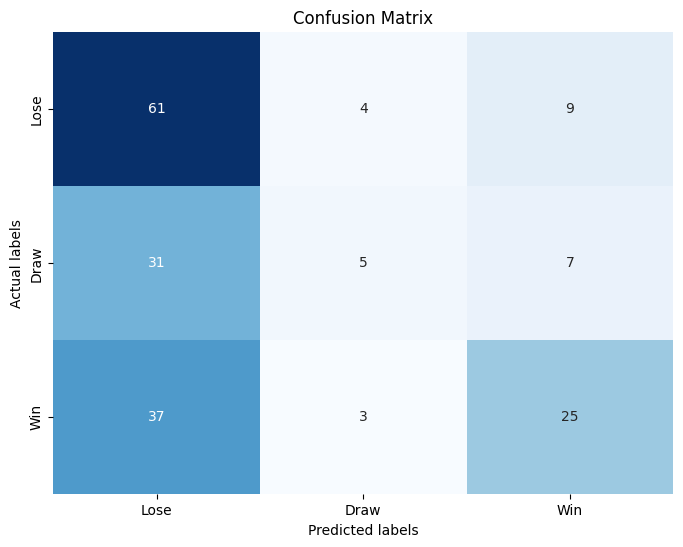

In [244]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, best_y_pred)

# Define the labels for the classes
class_labels = ['Lose', 'Draw', 'Win']

# Create a DataFrame for better label handling in seaborn heatmap
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()


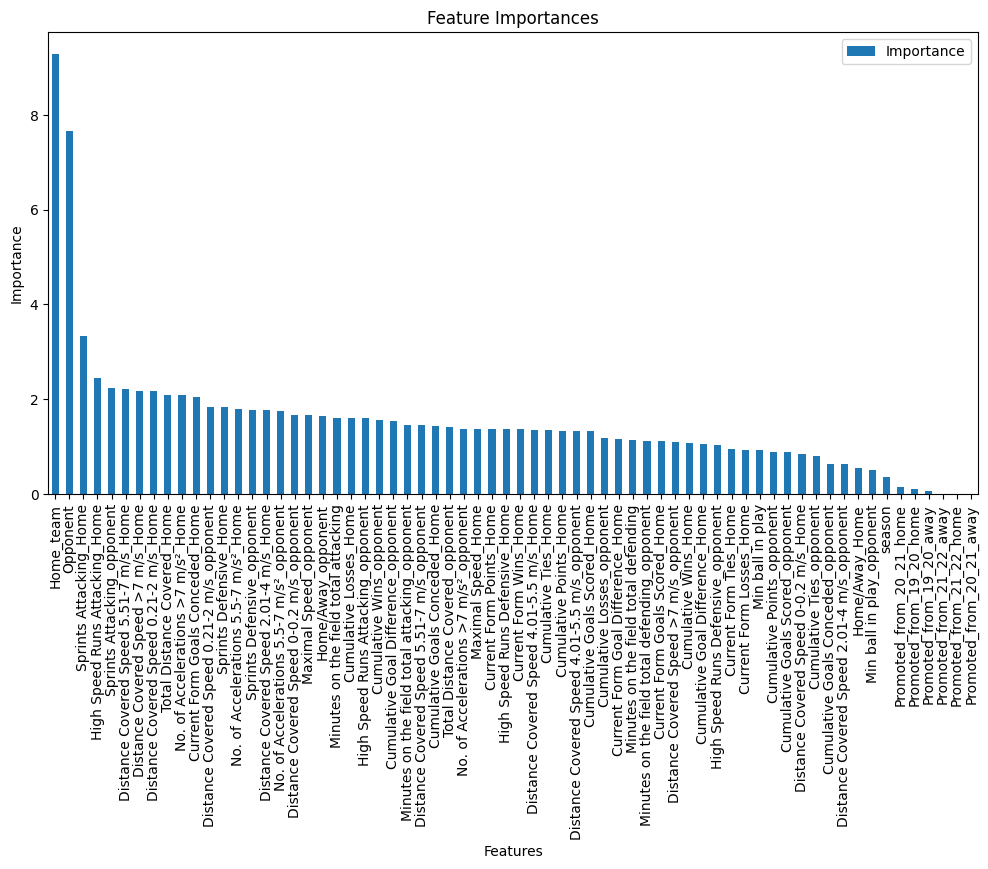

In [245]:
# Get feature importances
feature_importances = best_model.get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importances
importance_df.plot.bar(x='Feature', y='Importance', figsize=(12, 6))
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


In [ ]:
X_train.columns

Index(['Home_team', 'Total Distance Covered_Home',
       'Distance Covered Speed 0-0.2 m/s_Home',
       'Distance Covered Speed 0.21-2 m/s_Home',
       'Distance Covered Speed 2.01-4 m/s_Home',
       'Distance Covered Speed 4.01-5.5 m/s_Home',
       'Distance Covered Speed 5.51-7 m/s_Home',
       'Distance Covered Speed >7 m/s_Home',
       'No. of Accelerations 5.5-7 m/s²_Home',
       'No. of Accelerations >7 m/s²_Home', 'Maximal Speed_Home',
       'Cumulative Points_Home', 'Cumulative Goal Difference_Home',
       'Cumulative Goals Scored_Home', 'Cumulative Goals Conceded_Home',
       'Cumulative Wins_Home', 'Cumulative Losses_Home',
       'Cumulative Ties_Home', 'Current Form Points_Home',
       'Current Form Goal Difference_Home', 'Current Form Goals Scored_Home',
       'Current Form Goals Conceded_Home', 'Current Form Wins_Home',
       'Current Form Losses_Home', 'Current Form Ties_Home',
       'High Speed Runs Attacking_Home', 'High Speed Runs Defensive_Home',
     

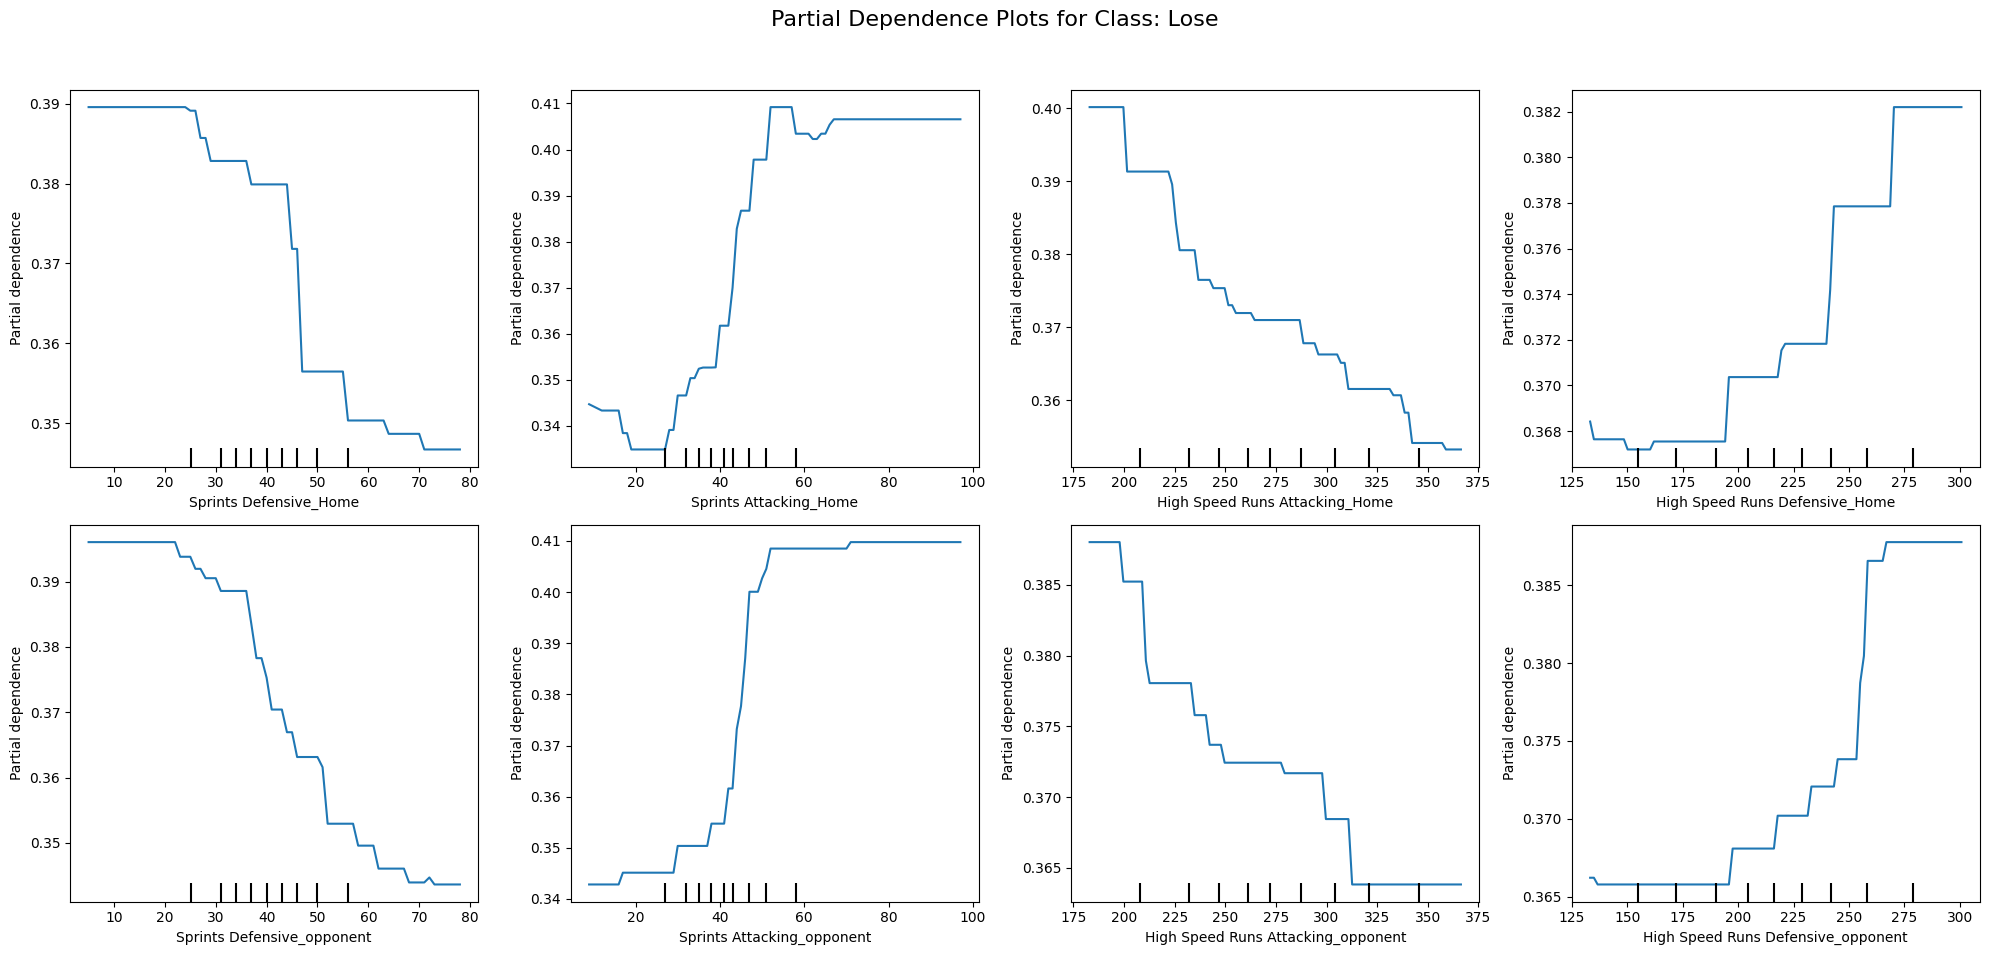

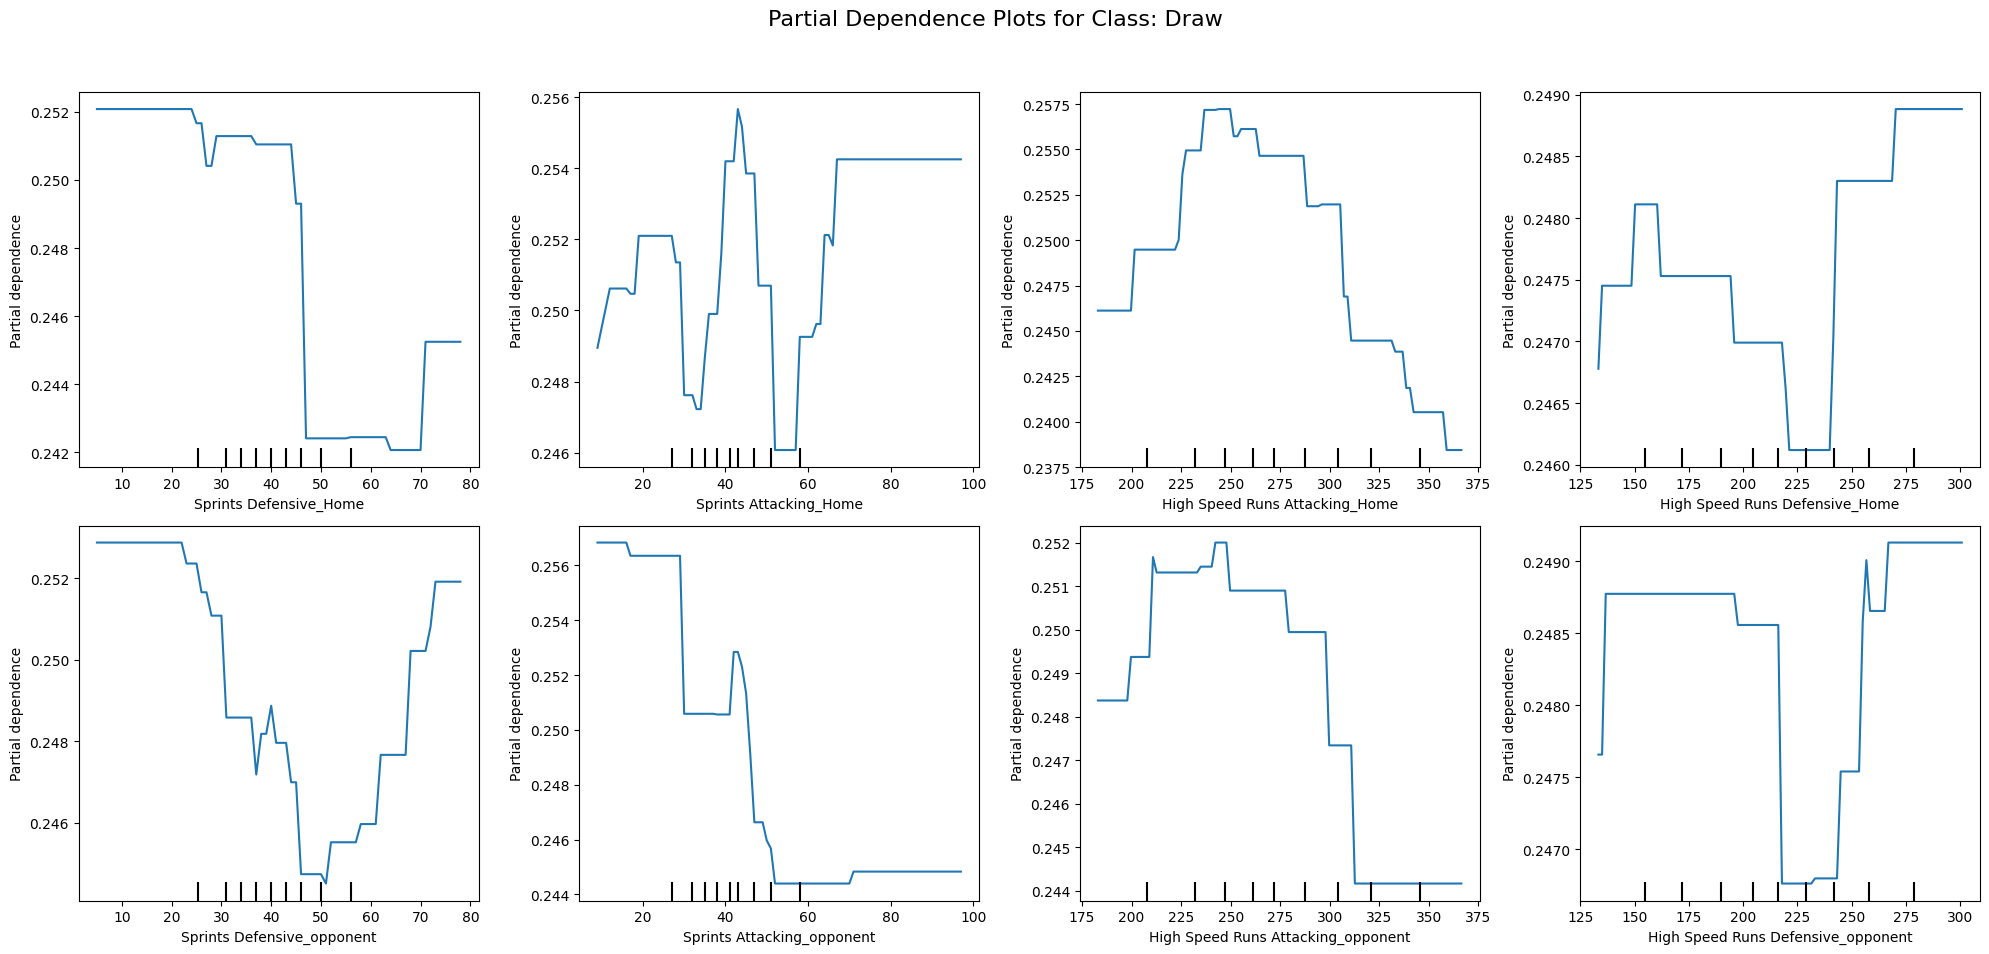

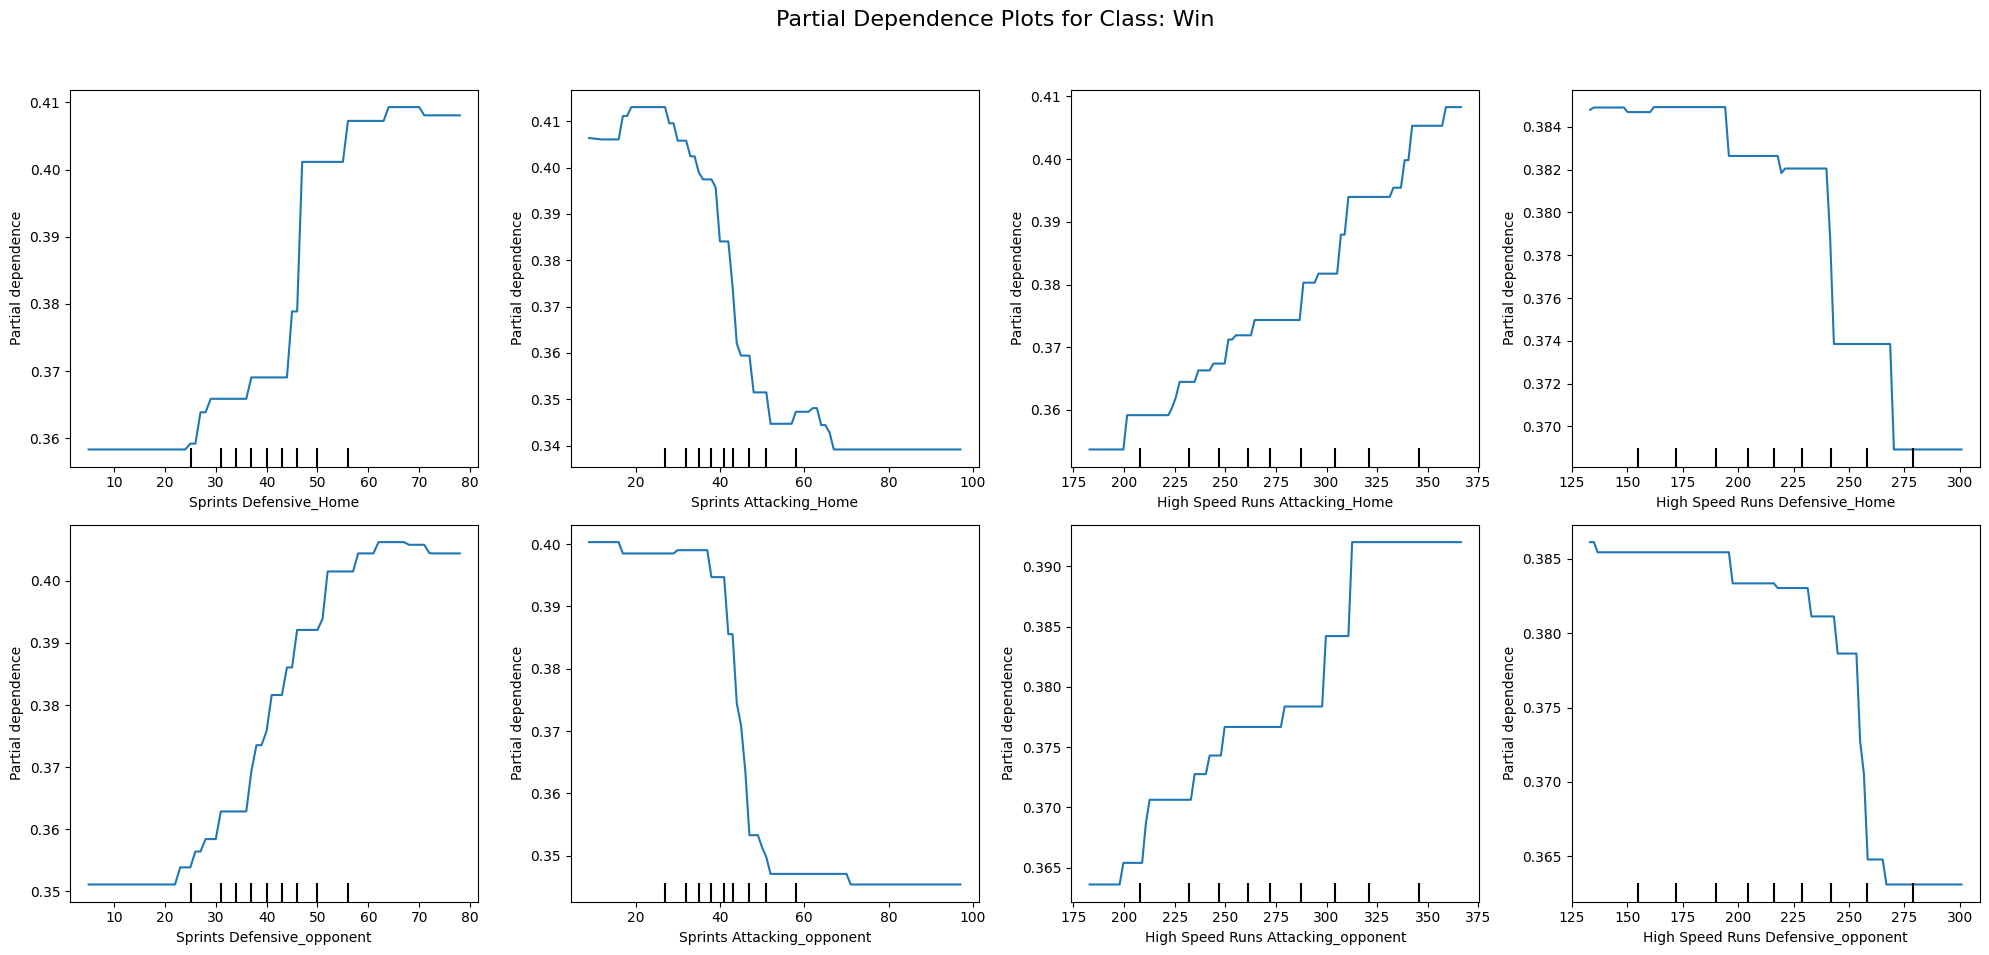

In [246]:
from sklearn.inspection import PartialDependenceDisplay

class_names = ['Lose', 'Draw', 'Win'] 

# Select features for which you want to plot the PDP
features = ['Sprints Defensive_Home', 'Sprints Attacking_Home','High Speed Runs Attacking_Home','High Speed Runs Defensive_Home',
            'Sprints Defensive_opponent', 'Sprints Attacking_opponent','High Speed Runs Attacking_opponent','High Speed Runs Defensive_opponent'
            ]  

# Loop through each class index and name
for class_index, class_name in enumerate(class_names):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    fig.suptitle(f'Partial Dependence Plots for Class: {class_name}', fontsize=16)
    
    for i, feature in enumerate(features):
        row = i // 4
        col = i % 4
        PartialDependenceDisplay.from_estimator(
            best_model,
            X_train,
            [feature],
            target=class_index,
            ax=axes[row, col]
        )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Overall Trends:

Defensive efforts (both high-speed runs and sprints) by the home team generally decrease the probability of losing and drawing while increasing the probability of winning.

Attacking efforts by the home team have mixed effects: increasing attacking sprints tend to increase winning chances but also increase losing probability up to a certain point.

The opponent's high-speed attacking and defensive efforts often decrease the home team's probability of losing and drawing, suggesting strategic counter-efforts.

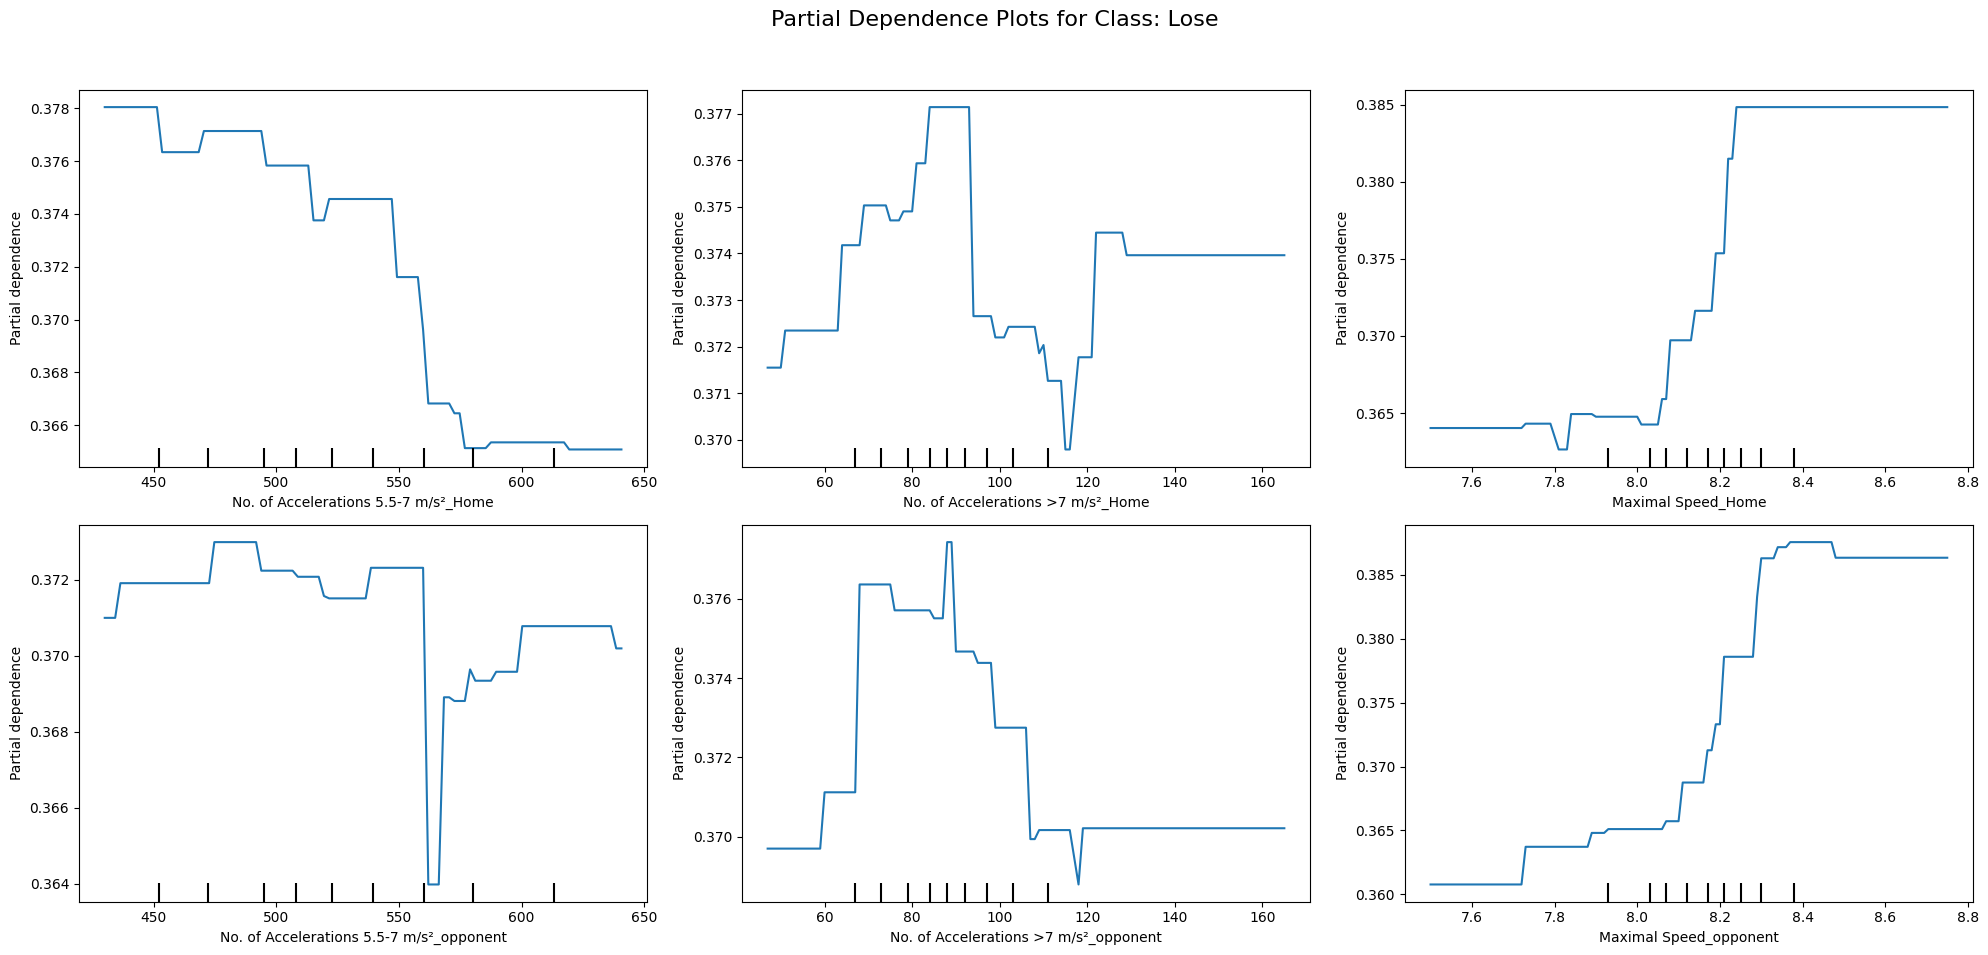

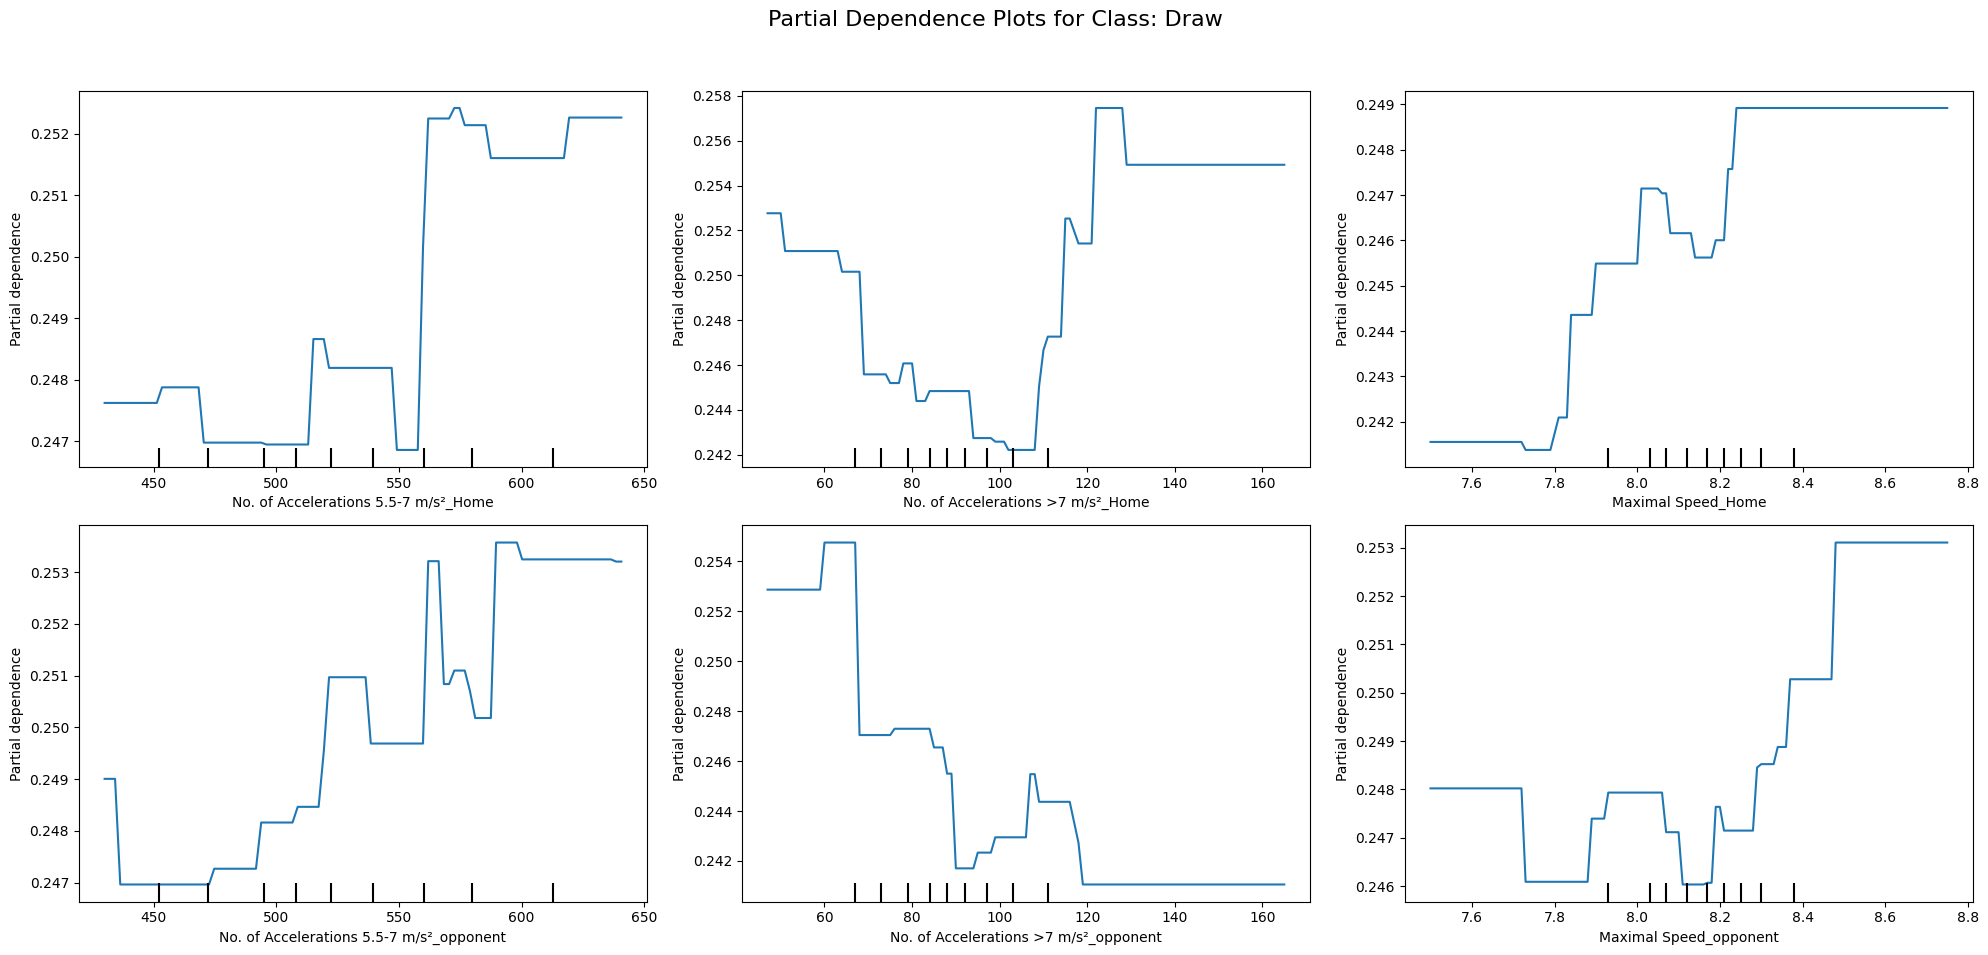

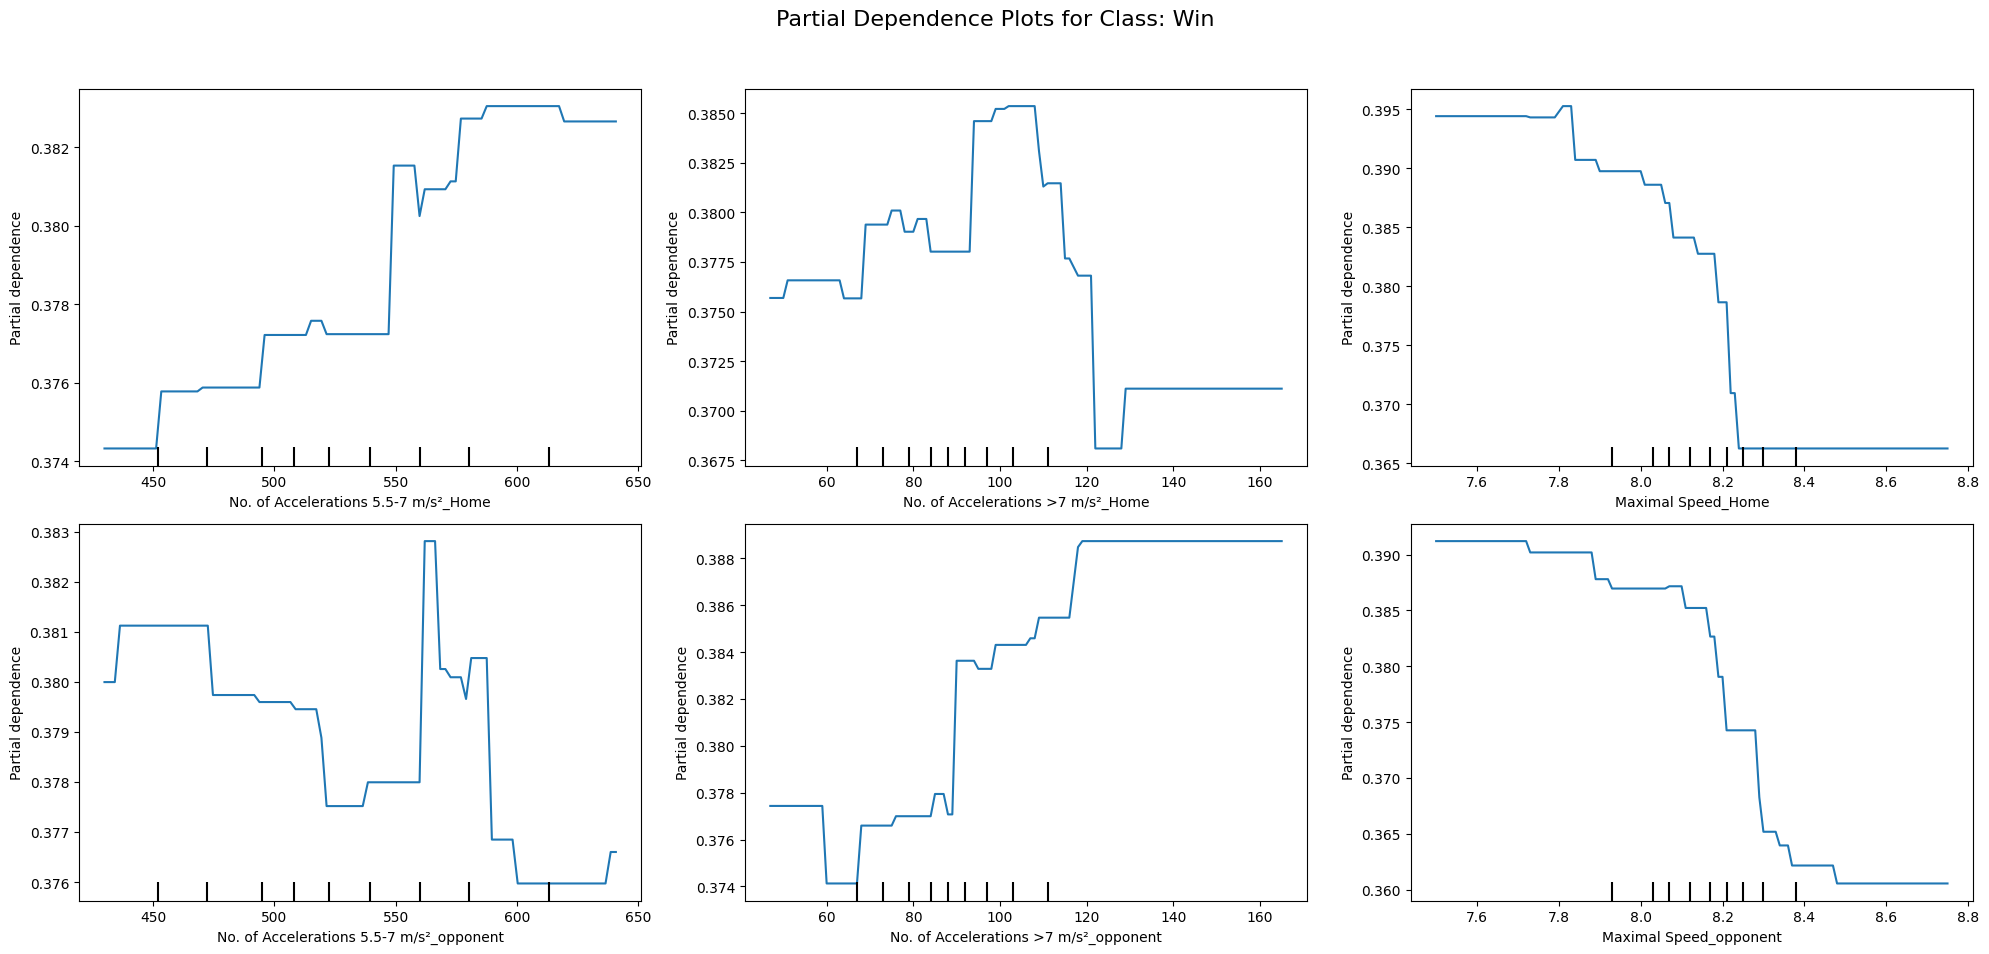

In [247]:
from sklearn.inspection import PartialDependenceDisplay

class_names = ['Lose', 'Draw', 'Win'] 

# Select features for which you want to plot the PDP
features = [ 'No. of Accelerations 5.5-7 m/s²_Home',
       'No. of Accelerations >7 m/s²_Home', 'Maximal Speed_Home', 'No. of Accelerations 5.5-7 m/s²_opponent',
       'No. of Accelerations >7 m/s²_opponent', 'Maximal Speed_opponent'
]  

# Loop through each class index and name
for class_index, class_name in enumerate(class_names):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
    fig.suptitle(f'Partial Dependence Plots for Class: {class_name}', fontsize=16)
    
    for i, feature in enumerate(features):
        row = i // 3
        col = i % 3
        PartialDependenceDisplay.from_estimator(
            best_model,
            X_train,
            [feature],
            target=class_index,
            ax=axes[row, col]
        )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Overall Trends:

Home Team Accelerations (5.5-7 m/s²): Increased accelerations in this range slightly improve winning chances and reduce losing and drawing probabilities.

Home Team High-Intensity Accelerations (>7 m/s²): Increased high-intensity accelerations initially improve winning chances but can lead to more losses and fewer draws beyond a certain point.

Home Team Maximal Speed: Higher maximal speeds correlate with increased losing and drawing probabilities while significantly reducing winning chances.

Opponent Accelerations (5.5-7 m/s²): Increased accelerations by the opponent in this range slightly increase the home team's winning chances and reduce the probability of draws.

Opponent High-Intensity Accelerations (>7 m/s²): More high-intensity accelerations by the opponent increase the home team's probability of losing and decrease their chances of drawing and winning.

Opponent Maximal Speed: Higher maximal speeds achieved by the opponent significantly increase the probability of the home team losing and drawing, while reducing the chances of winning.







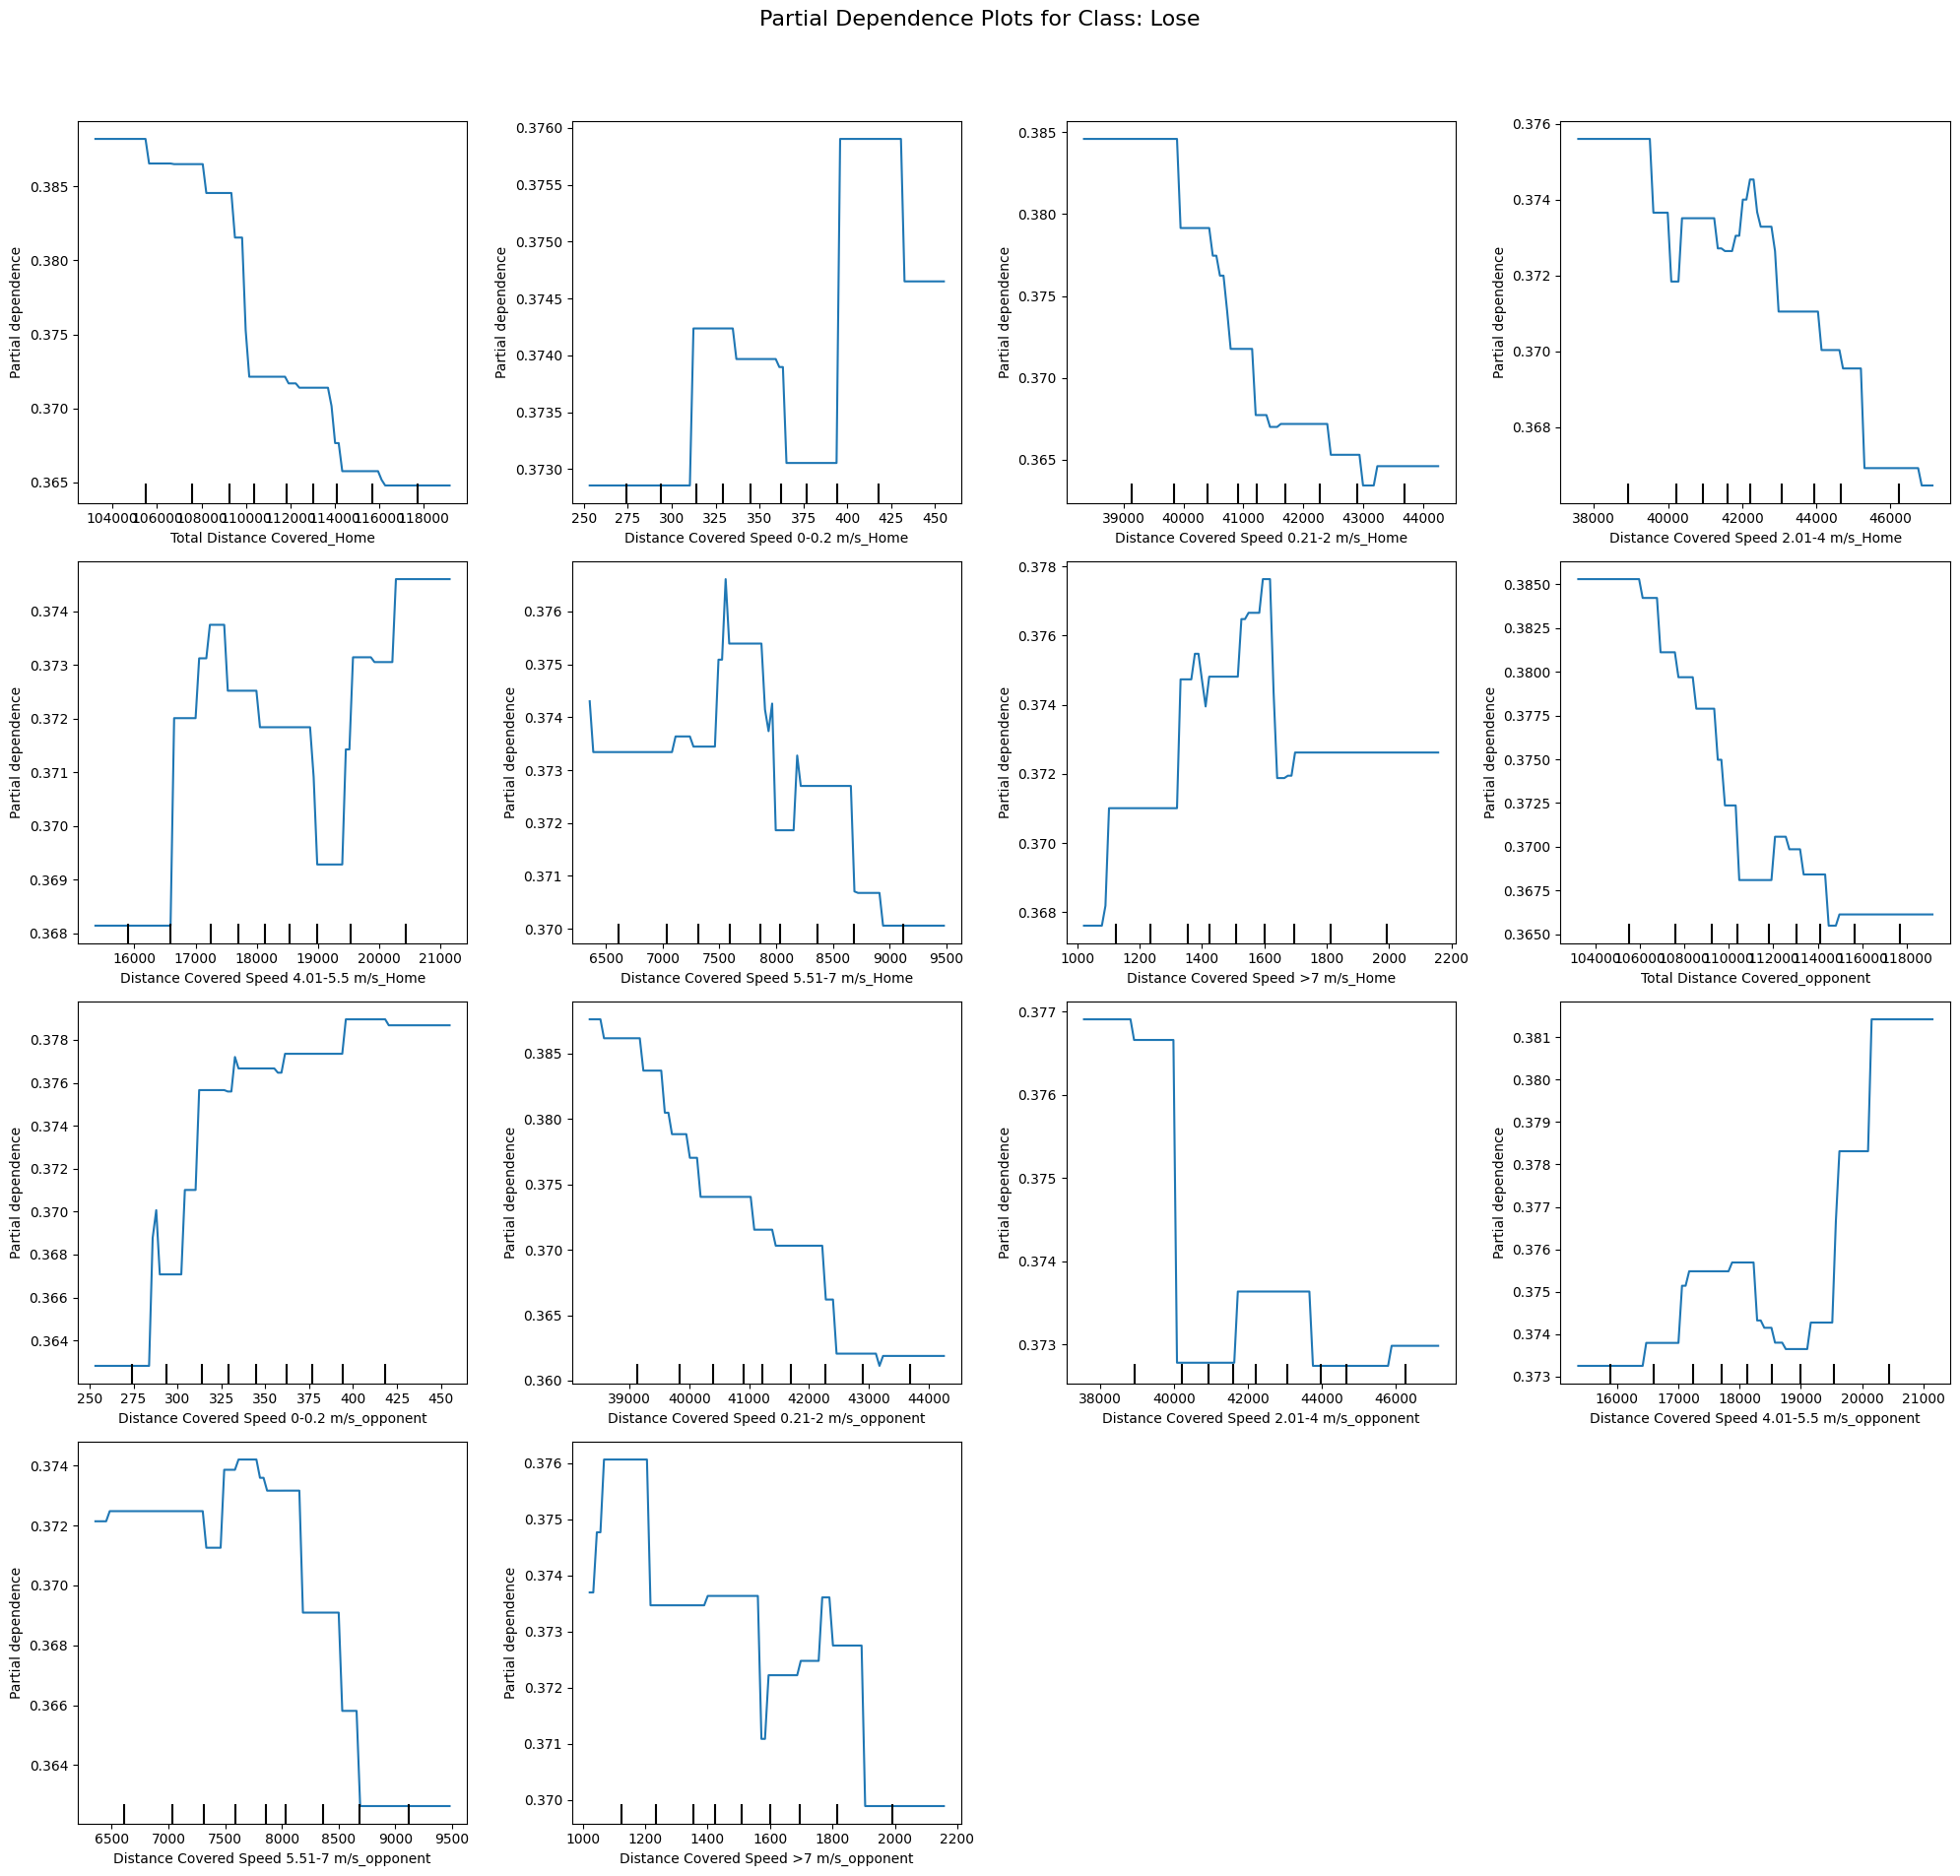

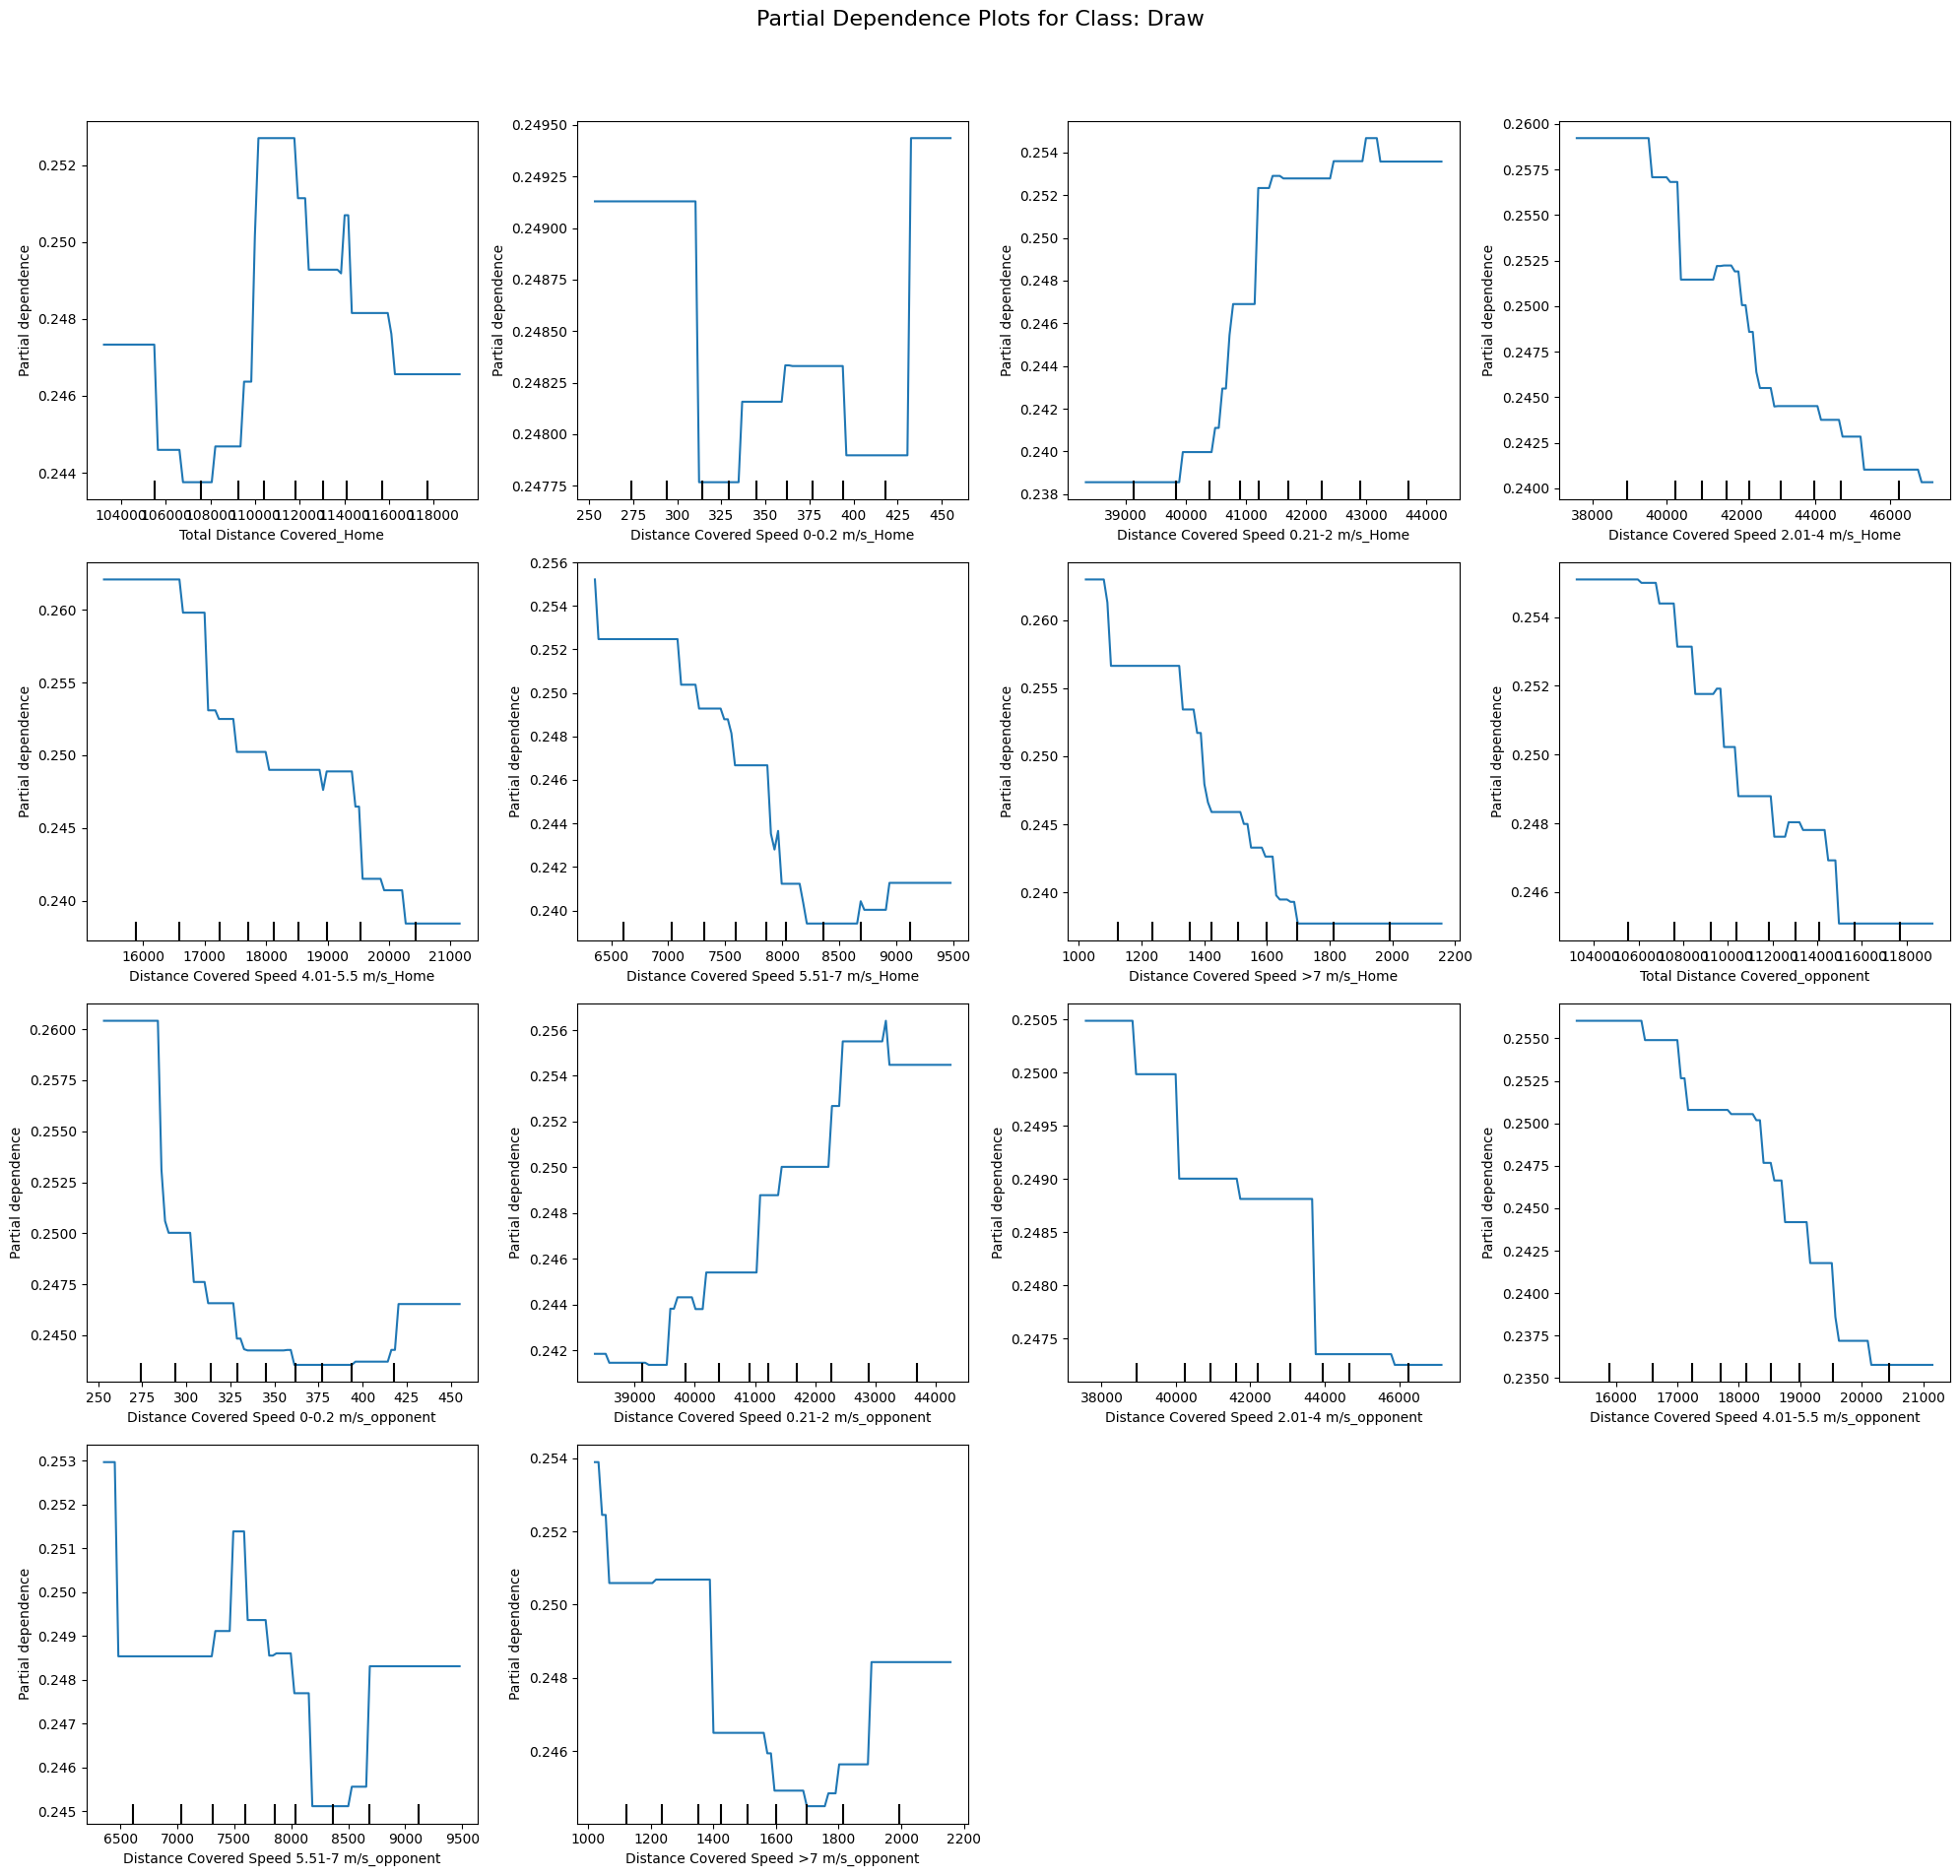

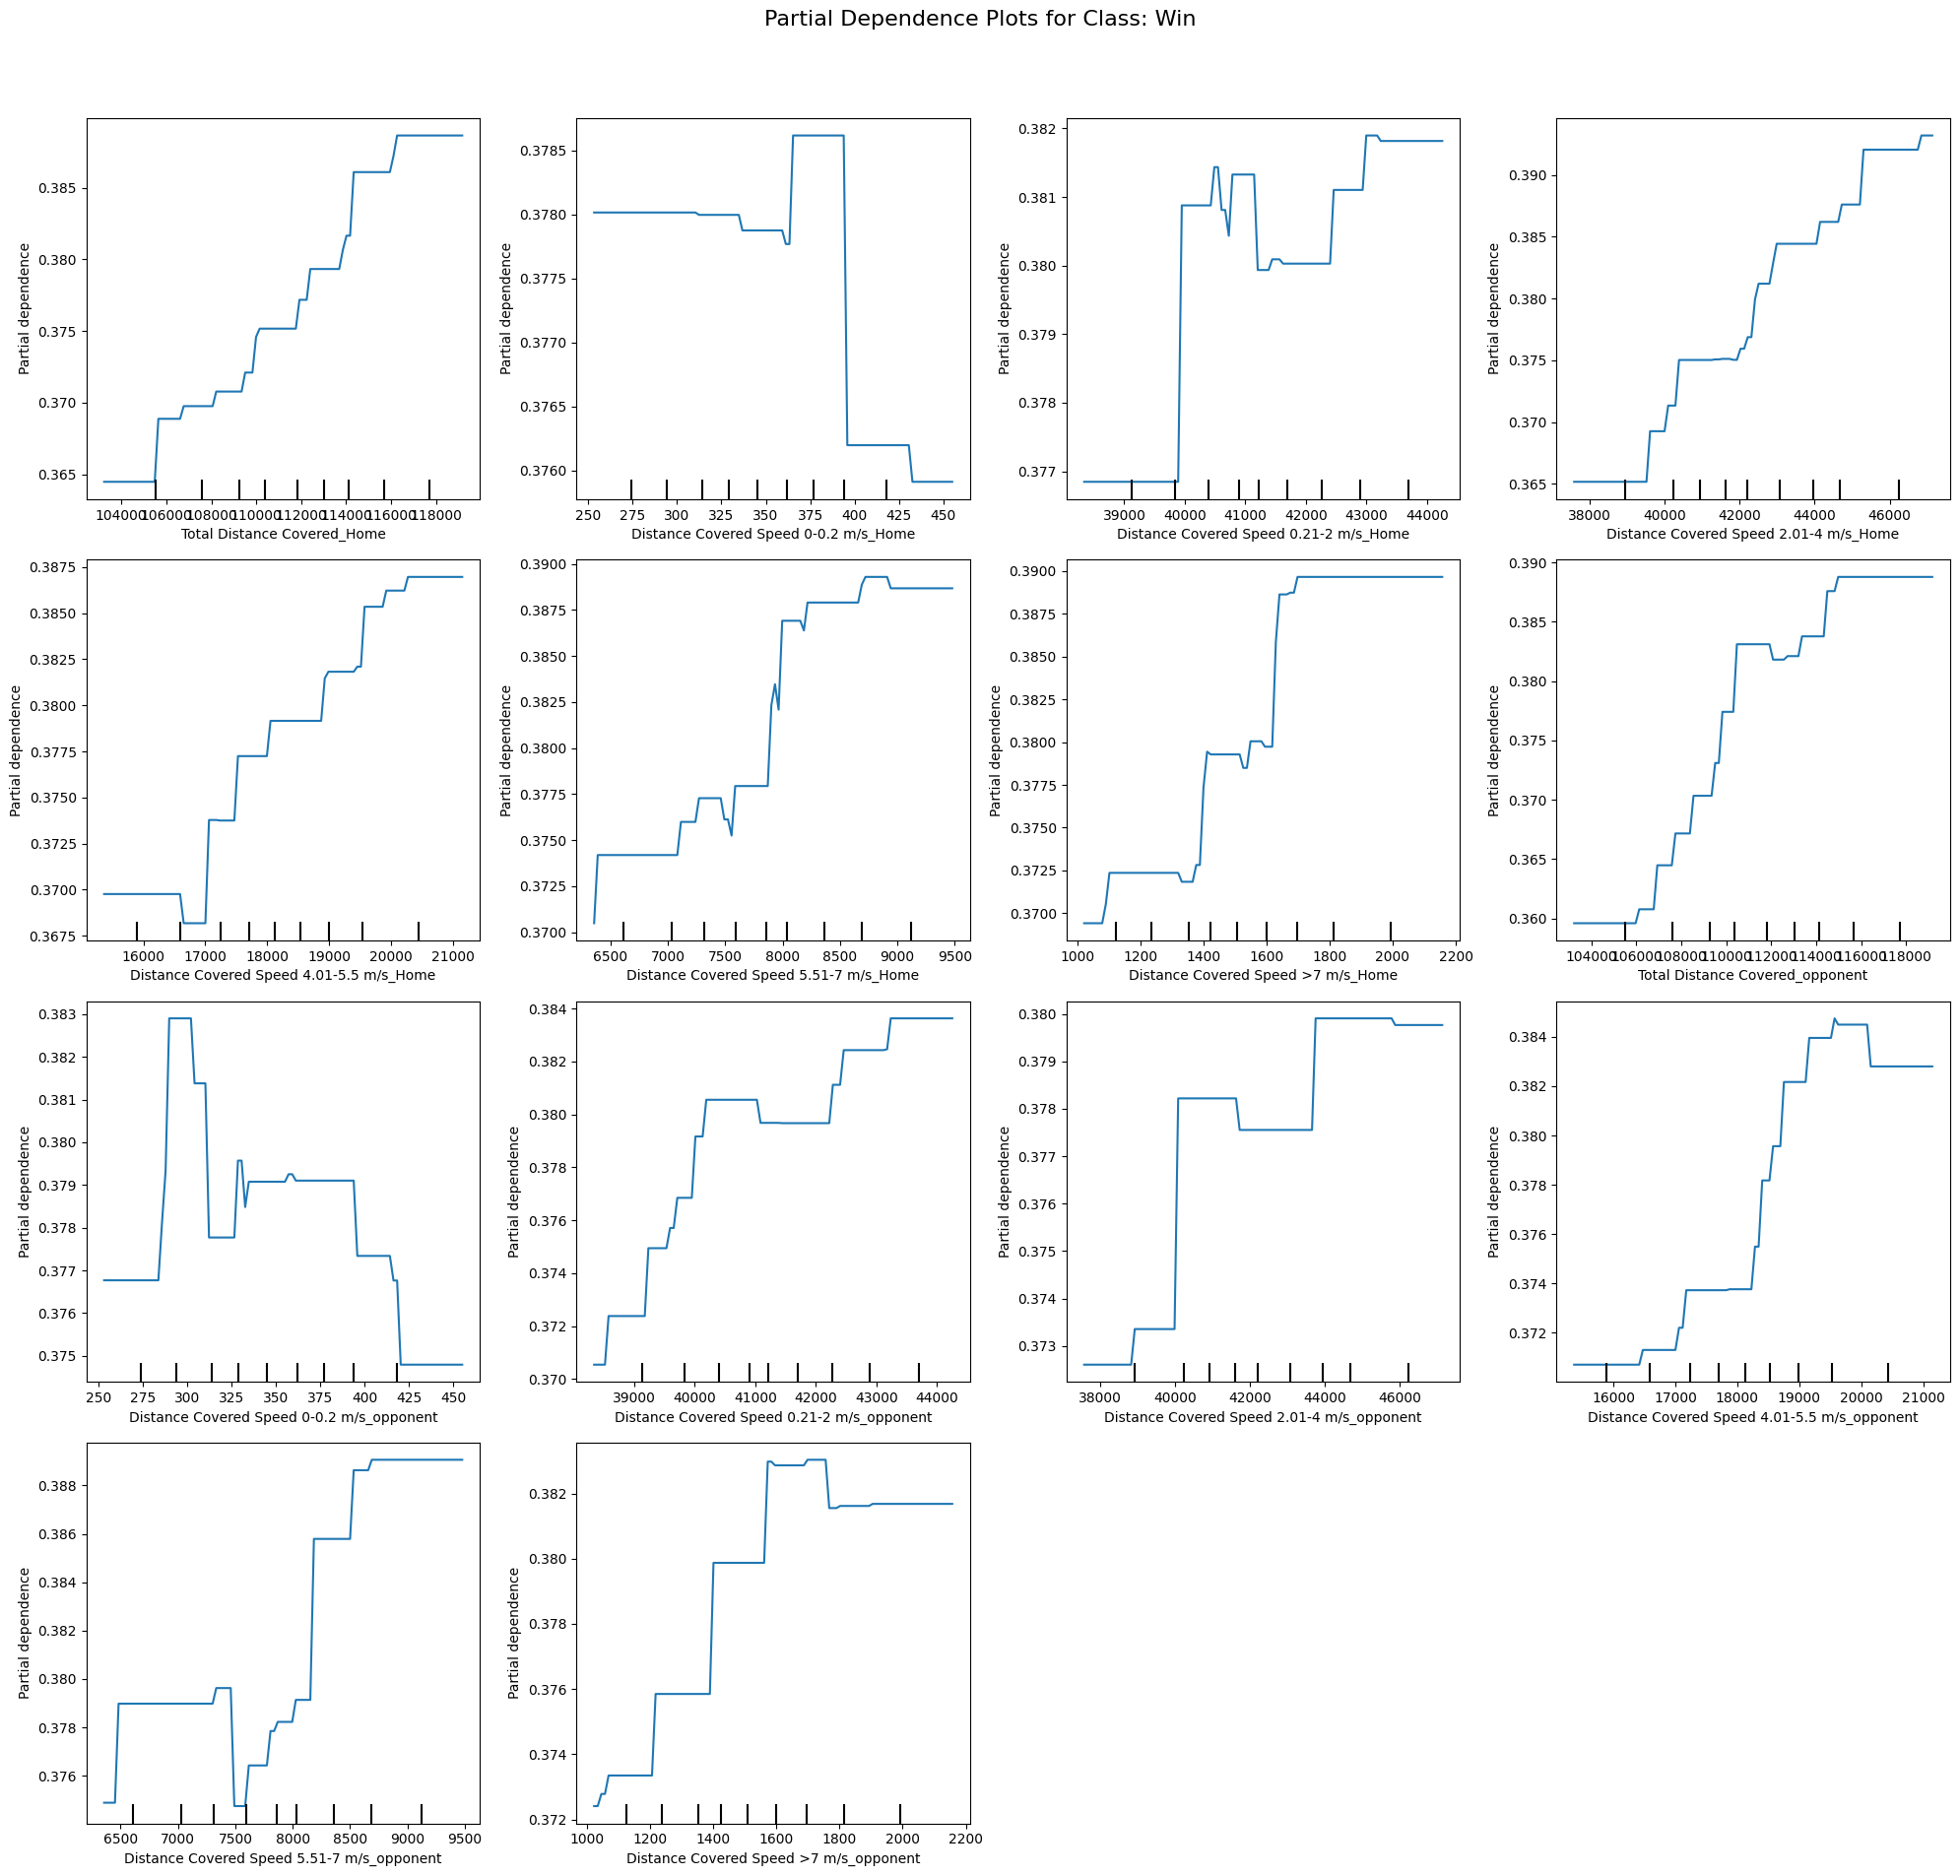

In [248]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

class_names = ['Lose', 'Draw', 'Win'] 

# Select features for which you want to plot the PDP
features = [
    'Total Distance Covered_Home', 'Distance Covered Speed 0-0.2 m/s_Home', 'Distance Covered Speed 0.21-2 m/s_Home',
    'Distance Covered Speed 2.01-4 m/s_Home', 'Distance Covered Speed 4.01-5.5 m/s_Home', 'Distance Covered Speed 5.51-7 m/s_Home',
    'Distance Covered Speed >7 m/s_Home', 'Total Distance Covered_opponent', 'Distance Covered Speed 0-0.2 m/s_opponent',
    'Distance Covered Speed 0.21-2 m/s_opponent', 'Distance Covered Speed 2.01-4 m/s_opponent', 'Distance Covered Speed 4.01-5.5 m/s_opponent',
    'Distance Covered Speed 5.51-7 m/s_opponent', 'Distance Covered Speed >7 m/s_opponent'
]

# Adjusting to 4 rows and 4 columns to fit all features
for class_index, class_name in enumerate(class_names):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    fig.suptitle(f'Partial Dependence Plots for Class: {class_name}', fontsize=16)
    
    for i, feature in enumerate(features):
        row = i // 4
        col = i % 4
        PartialDependenceDisplay.from_estimator(
            best_model,
            X_train,
            [feature],
            target=class_index,
            ax=axes[row, col]
        )
    
    # Hide any empty subplots
    for j in range(len(features), 16):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Summary:

Home Team Performance:

The more distance the home team covers at various speeds, particularly at moderate to high speeds, the higher the probability of winning.

Very high-speed efforts by the home team can slightly increase the probability of both winning and losing.

Opponent Performance:

The more distance the opponent covers, particularly at higher speeds, the higher the probability of the home team losing.

However, increased opponent activity also correlates with higher chances of the home team winning, suggesting more dynamic and contested matches.







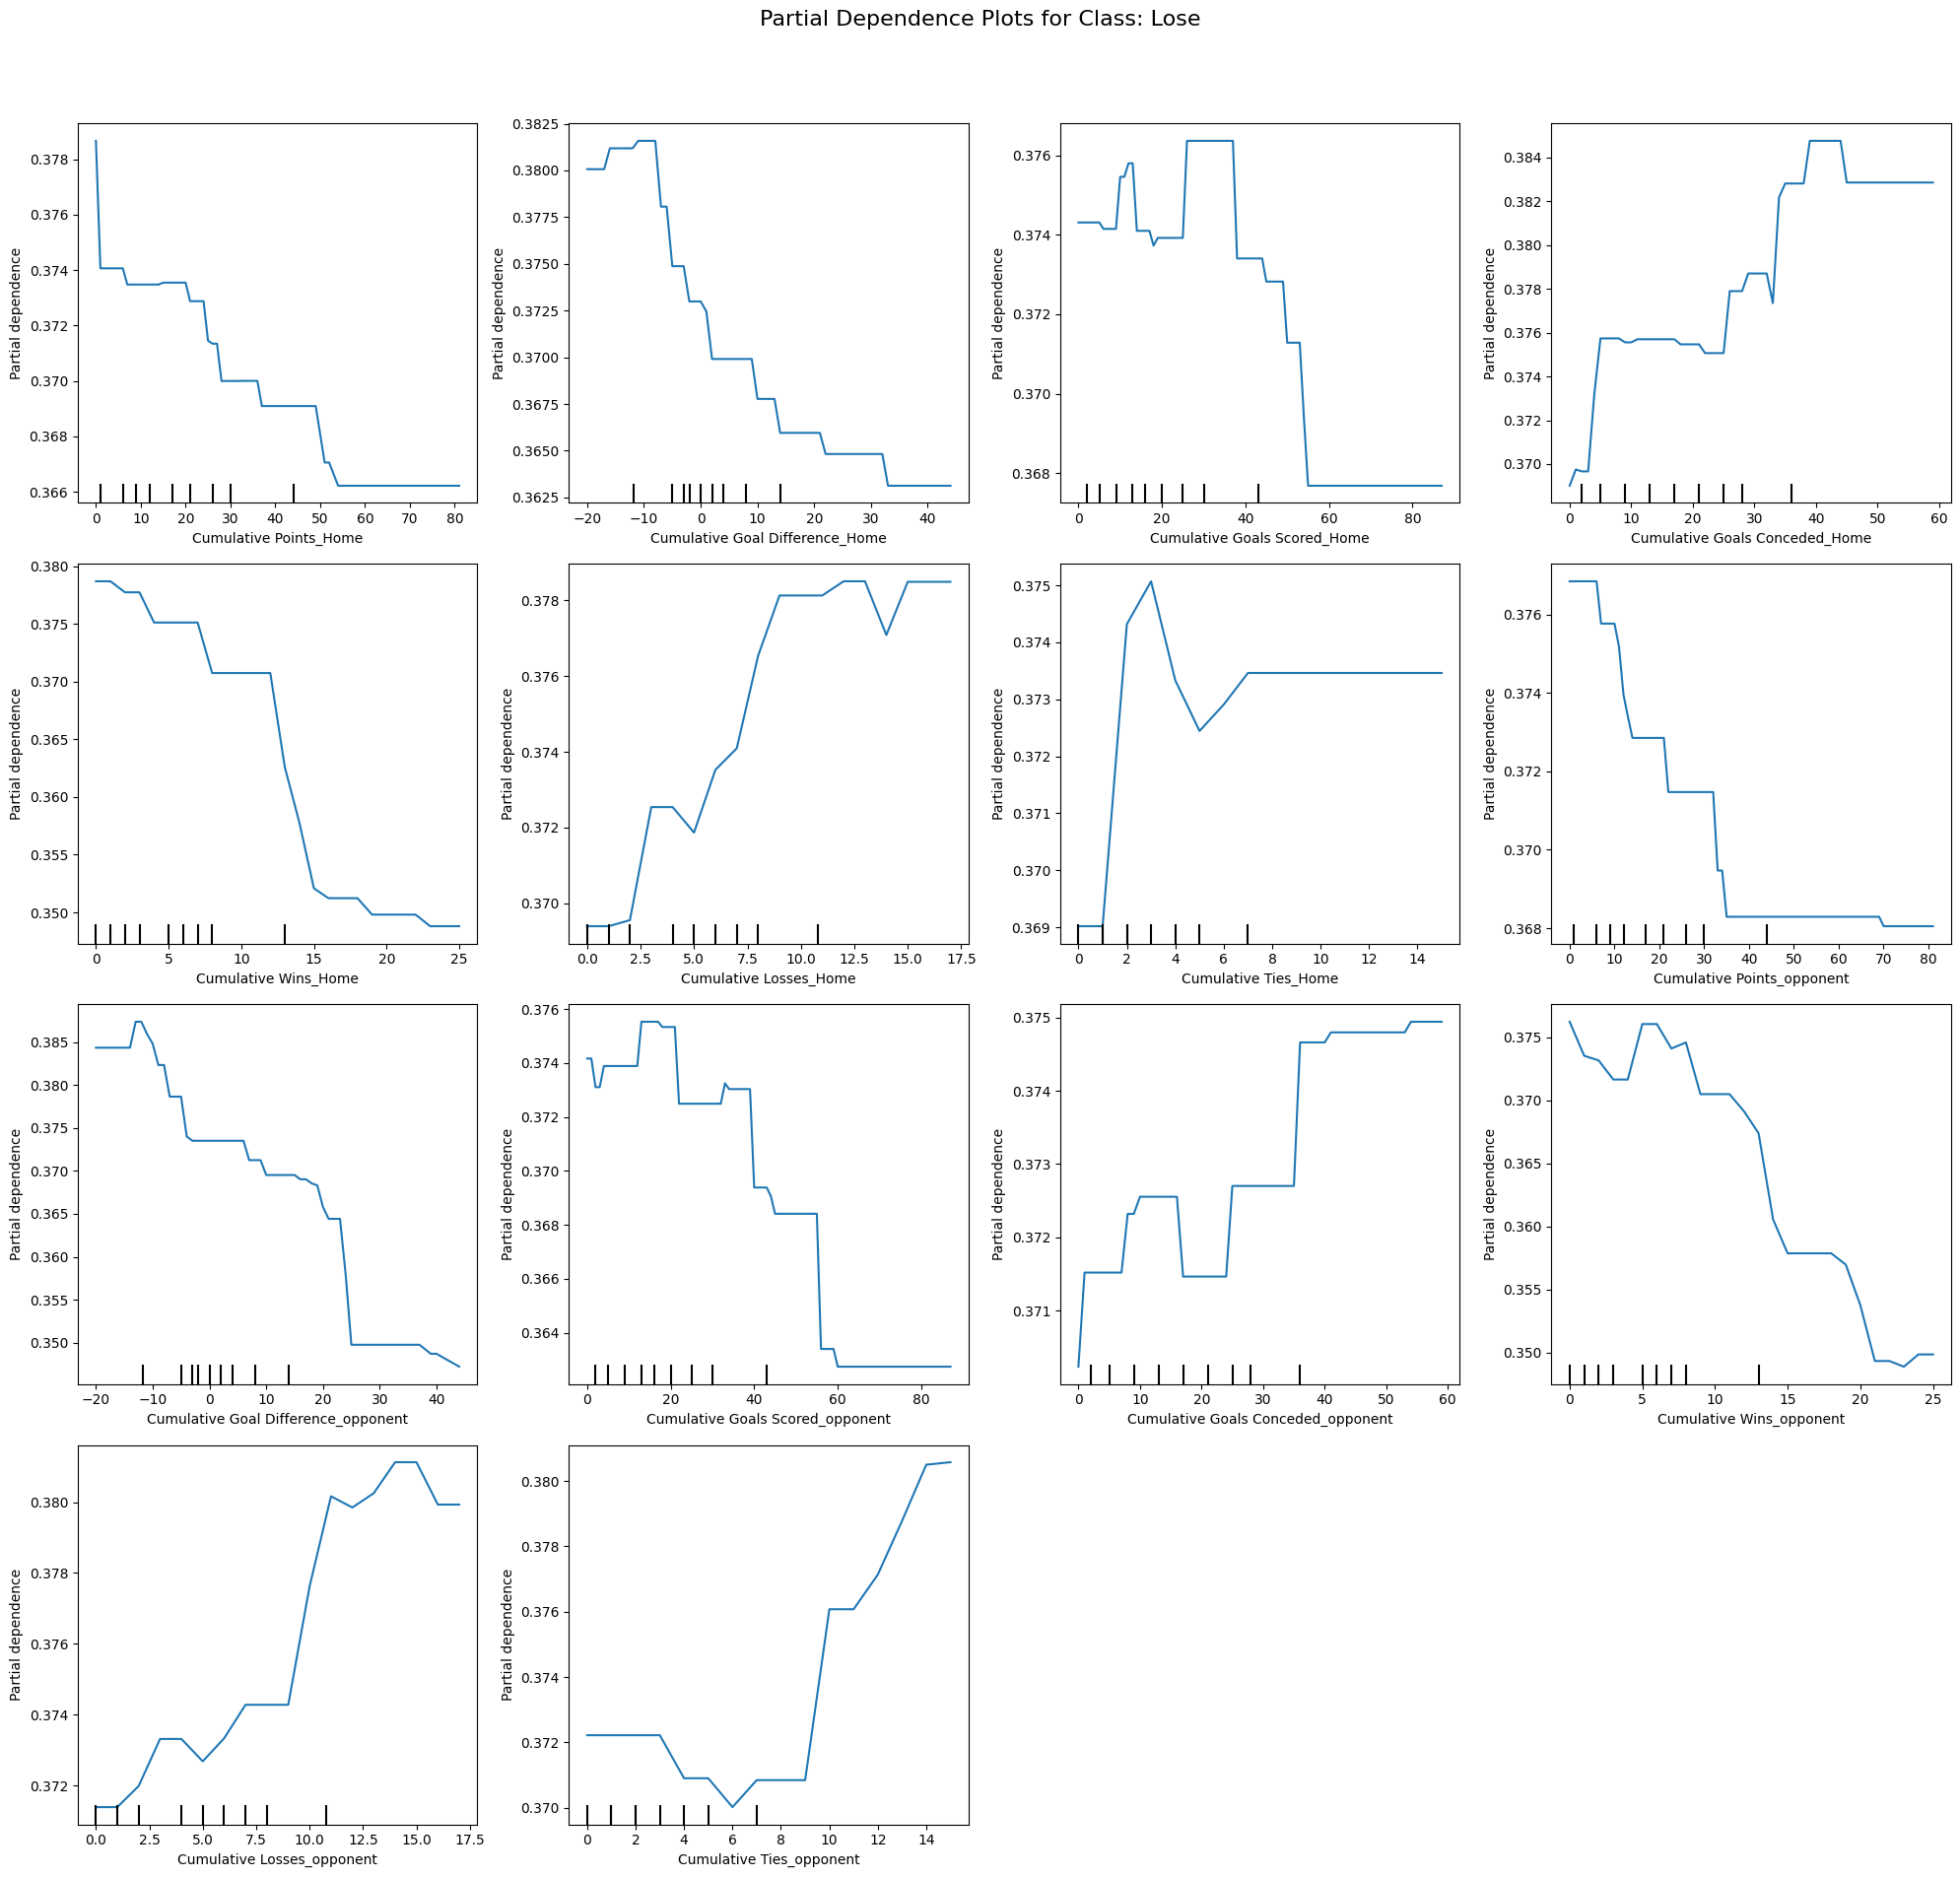

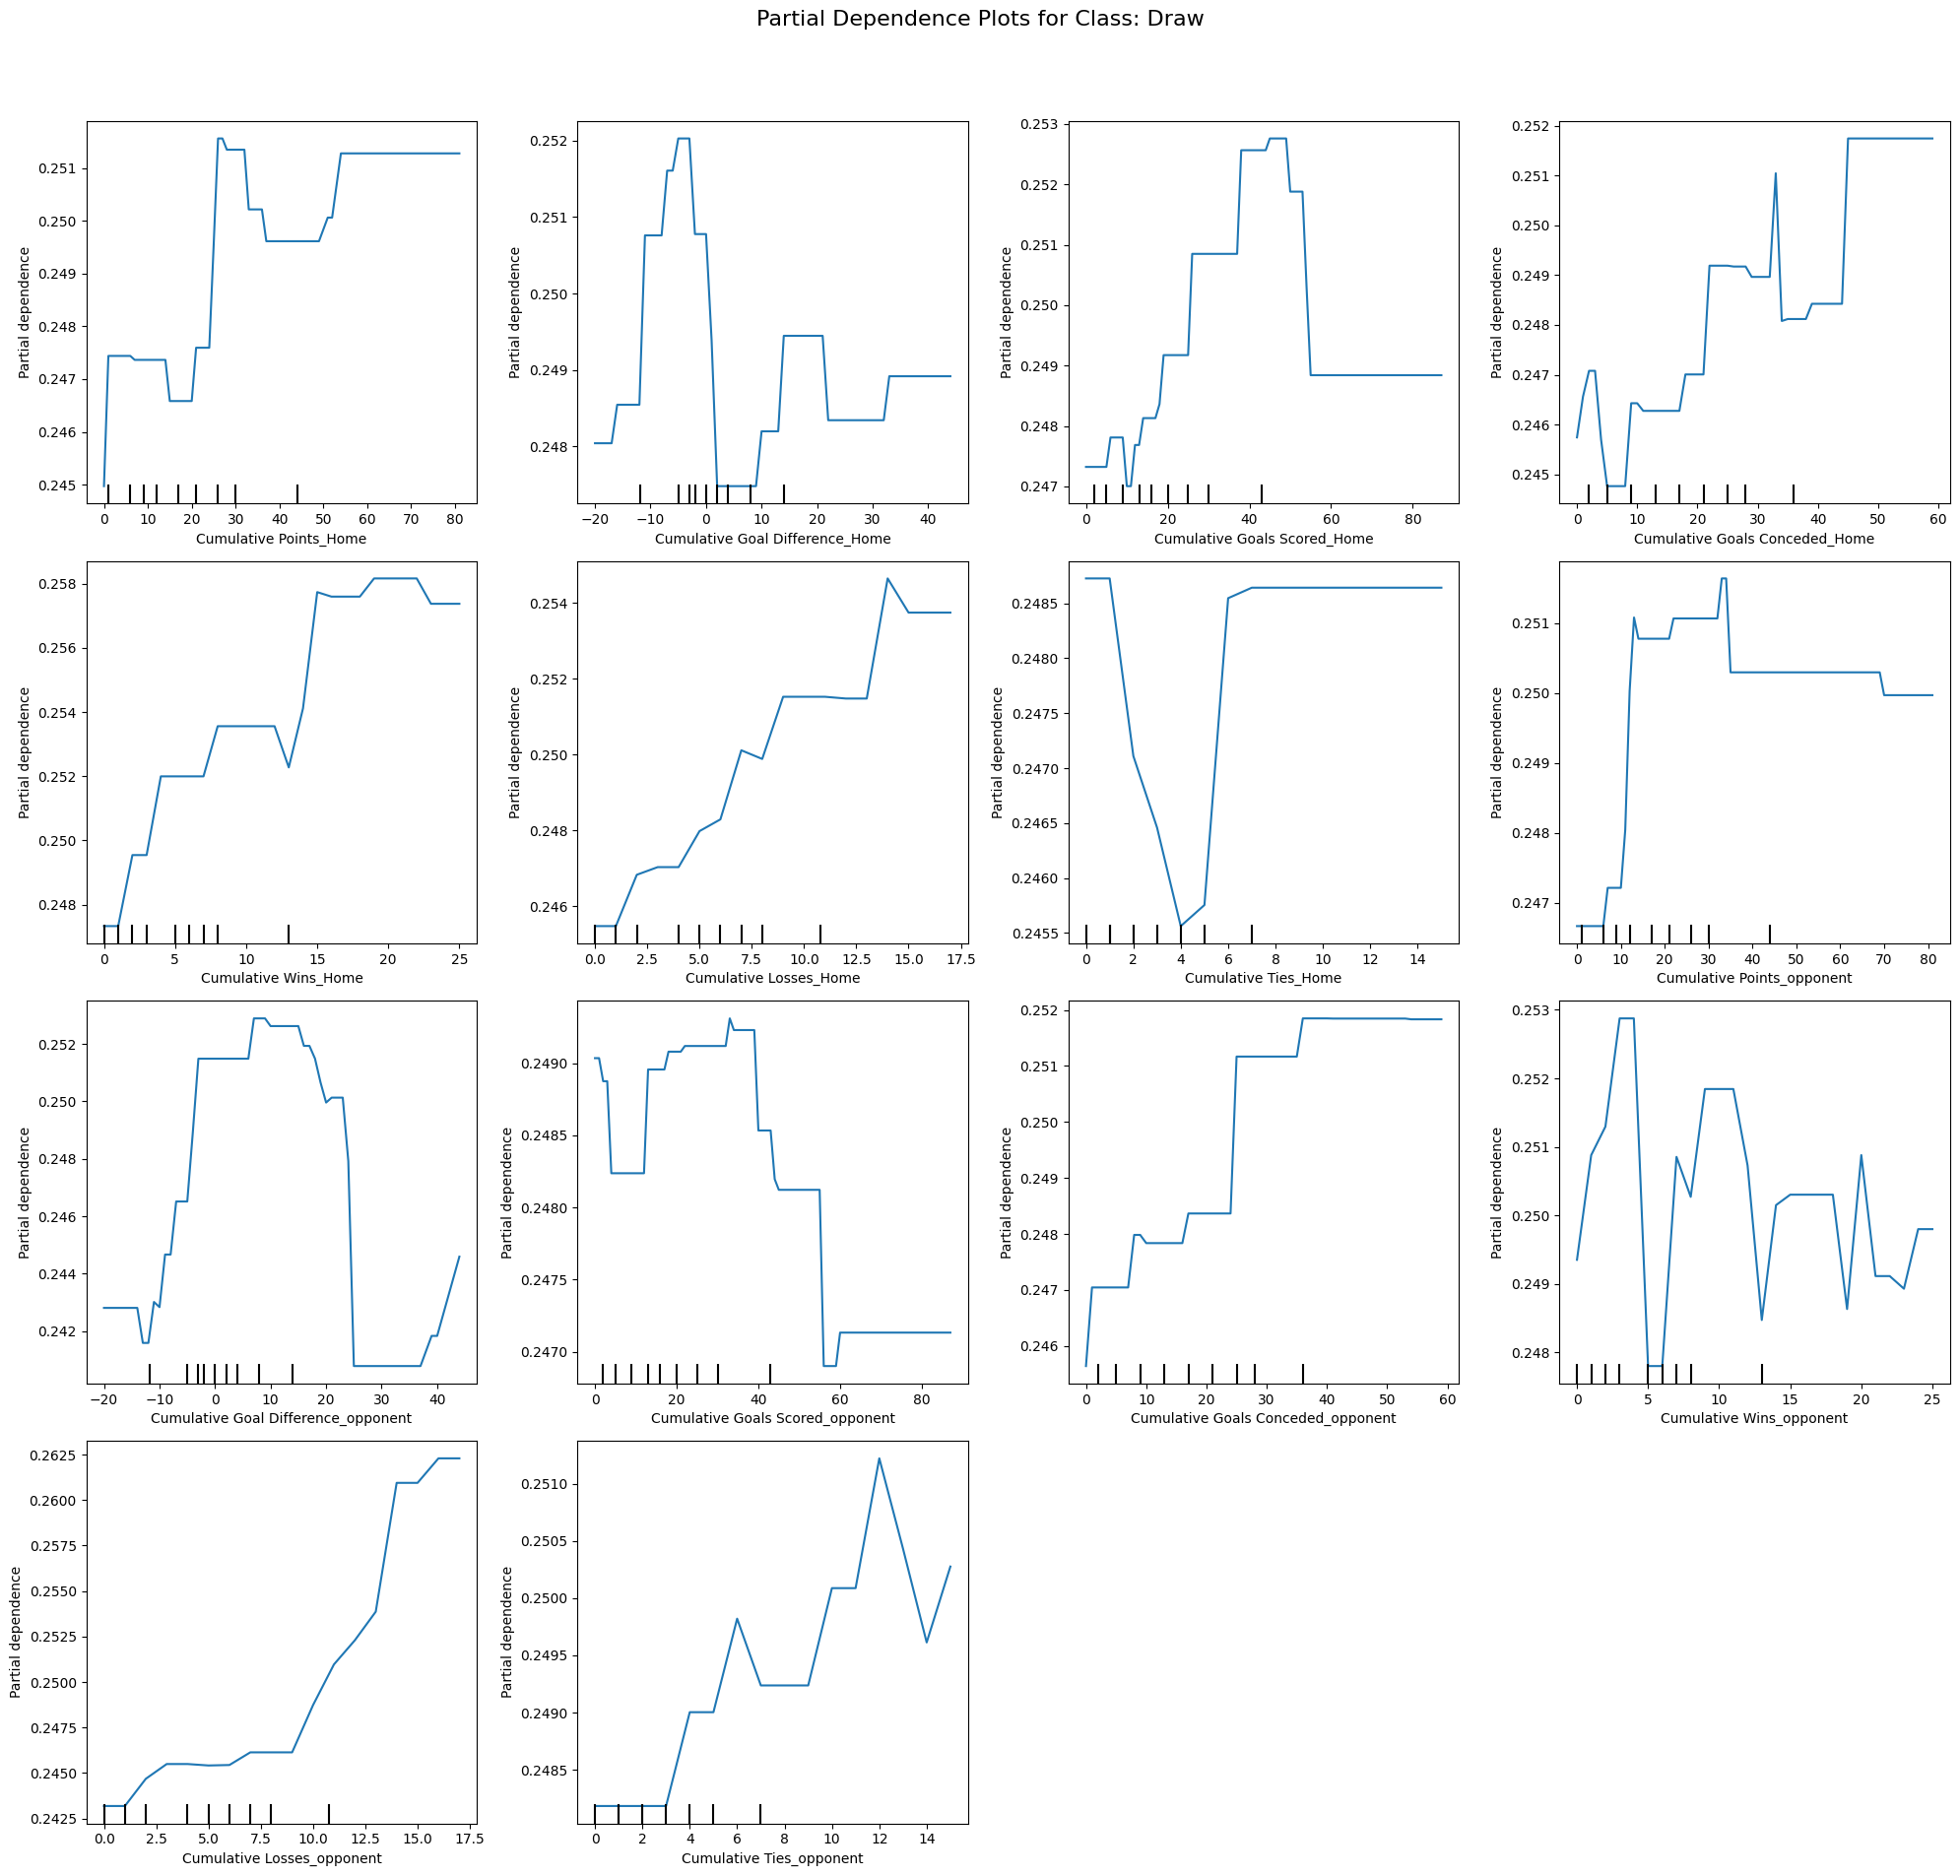

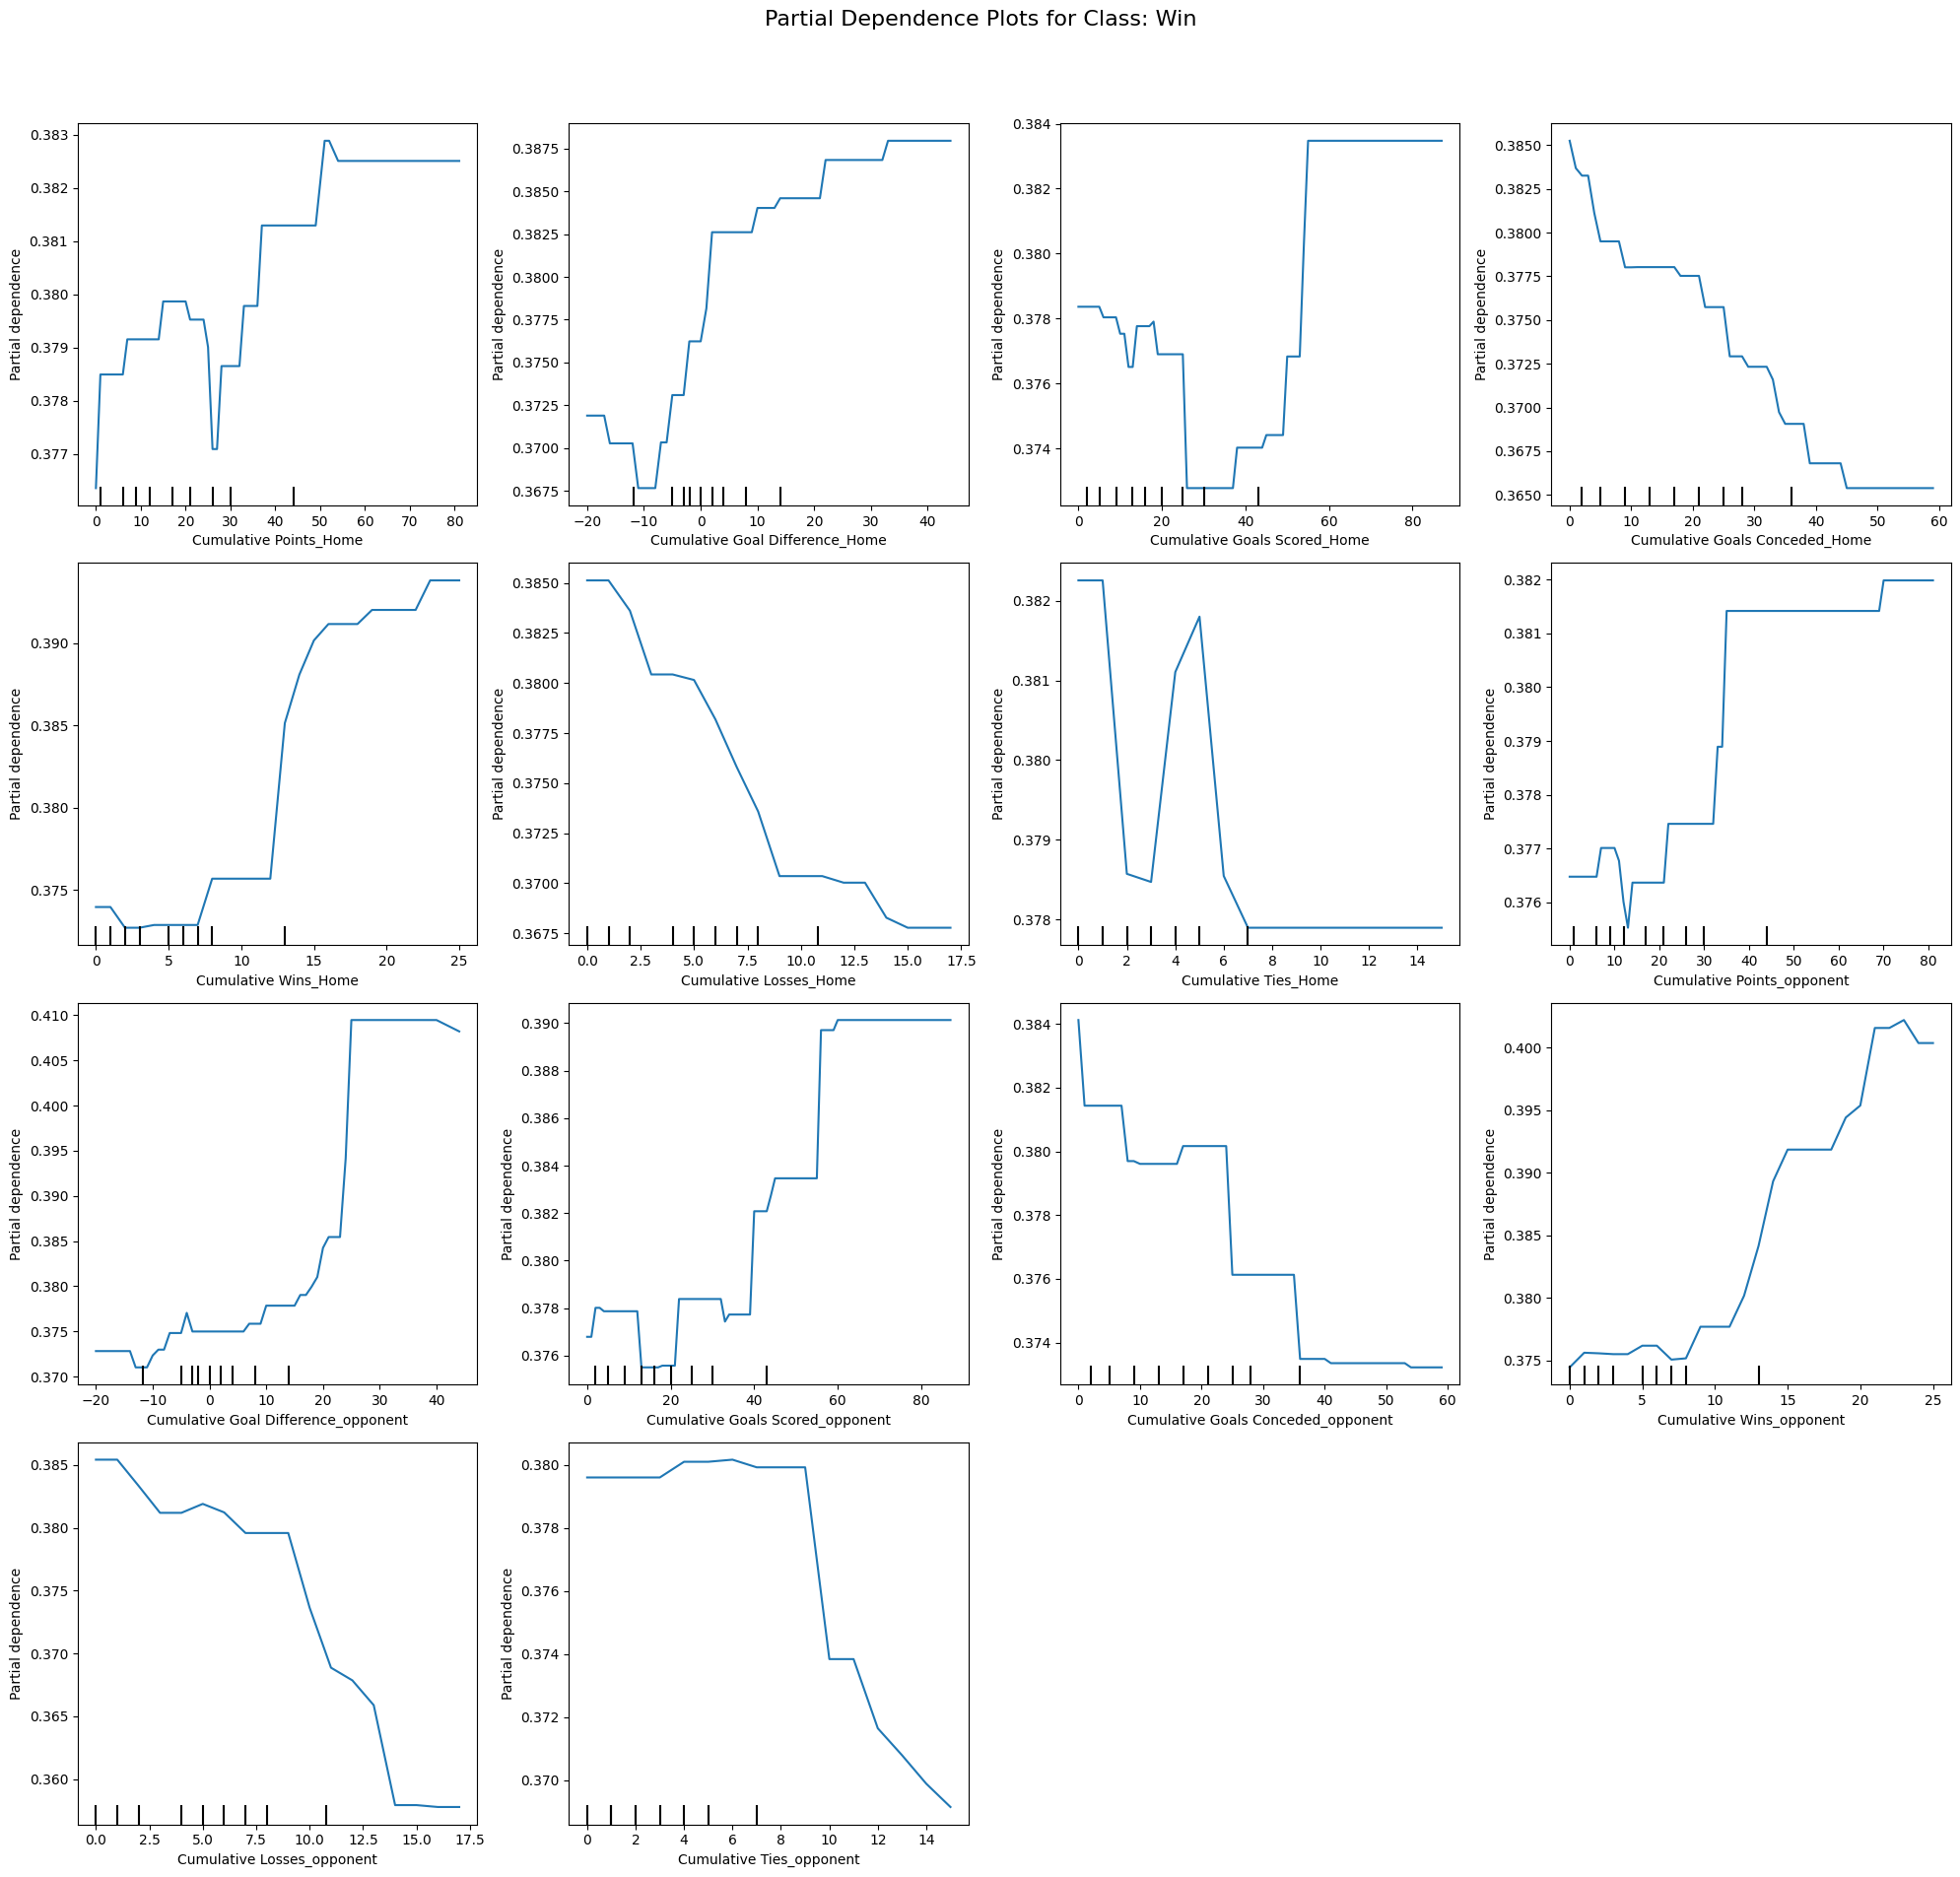

In [249]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

class_names = ['Lose', 'Draw', 'Win'] 

# Select features for which you want to plot the PDP
features = [
       'Cumulative Points_Home', 'Cumulative Goal Difference_Home',
       'Cumulative Goals Scored_Home', 'Cumulative Goals Conceded_Home',
       'Cumulative Wins_Home', 'Cumulative Losses_Home',
       'Cumulative Ties_Home', 'Cumulative Points_opponent', 'Cumulative Goal Difference_opponent',
       'Cumulative Goals Scored_opponent',
       'Cumulative Goals Conceded_opponent', 'Cumulative Wins_opponent',
       'Cumulative Losses_opponent', 'Cumulative Ties_opponent']

# Adjusting to 4 rows and 4 columns to fit all features
for class_index, class_name in enumerate(class_names):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    fig.suptitle(f'Partial Dependence Plots for Class: {class_name}', fontsize=16)
    
    for i, feature in enumerate(features):
        row = i // 4
        col = i % 4
        PartialDependenceDisplay.from_estimator(
            best_model,
            X_train,
            [feature],
            target=class_index,
            ax=axes[row, col]
        )
    
    # Hide any empty subplots
    for j in range(len(features), 16):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Summary:

Home Team Performance:

Positive metrics for the home team (e.g., cumulative points, goal difference, goals scored) generally correlate with higher probabilities of winning and lower probabilities of losing and drawing.

Negative metrics (e.g., goals conceded, losses, ties) increase the probability of losing and decrease the probability of winning.

Opponent Performance:

Positive metrics for the opponent (e.g., cumulative points, goal difference, goals scored) generally correlate with lower probabilities of the home team losing and drawing, and higher probabilities of the home team winning.

Negative metrics for the opponent (e.g., goals conceded, losses, ties) increase the probability of the home team losing and drawing, while decreasing the probability of the home team winning.



In [259]:
!pip install --upgrade shap

In [252]:
X_train

Home_team  Total Distance Covered_Home  \
0      Fenerbahce                       111784   
1       Kasimpasa                       114153   
2      Alanyaspor                       109381   
3     Kayserispor                       110355   
5       Hatayspor                       114306   
...           ...                          ...   
1363  Giresunspor                       109885   
1367  Galatasaray                       112269   
1397  Giresunspor                       116832   
1401  Galatasaray                       114098   
1433  Galatasaray                       110213   

      Distance Covered Speed 0-0.2 m/s_Home  \
0                                       279   
1                                       276   
2                                       355   
3                                       232   
5                                       297   
...                                     ...   
1363                                    358   
1367                                    410   
1397                                    349   
1401                                    287   
1433                                    317   

      Distance Covered Speed 0.21-2 m/s_Home  \
0                                      42168   
1                                      39961   
2                                      42605   
3                                      43845   
5                                      41501   
...                                      ...   
1363                                   41110   
1367                                   41958   
1397                                   43915   
1401                                   42115   
1433                                   38439   

      Distance Covered Speed 2.01-4 m/s_Home  \
0                                      43537   
1                                      44998   
2                                      41928   
3                                      44061   
5                                      44260   
...                                      ...   
1363                                   40051   
1367                                   40853   
1397                                   43850   
1401                                   41849   
1433                                   41946   

      Distance Covered Speed 4.01-5.5 m/s_Home  \
0                                        16792   
1                                        19583   
2                                        16425   
3                                        15360   
5                                        17930   
...                                        ...   
1363                                     18510   
1367                                     18693   
1397                                     18671   
1401                                     20030   
1433                                     19351   

      Distance Covered Speed 5.51-7 m/s_Home  \
0                                       7481   
1                                       7853   
2                                       6991   
3                                       5918   
5                                       8198   
...                                      ...   
1363                                    8278   
1367                                    8535   
1397                                    8762   
1401                                    8203   
1433                                    8551   

      Distance Covered Speed >7 m/s_Home  \
0                                   1535   
1                                   1495   
2                                   1098   
3                                    969   
5                                   2159   
...                                  ...   
1363                                1593   
1367                                1865   
1397                                1290   
1401                                1638   
1433                      

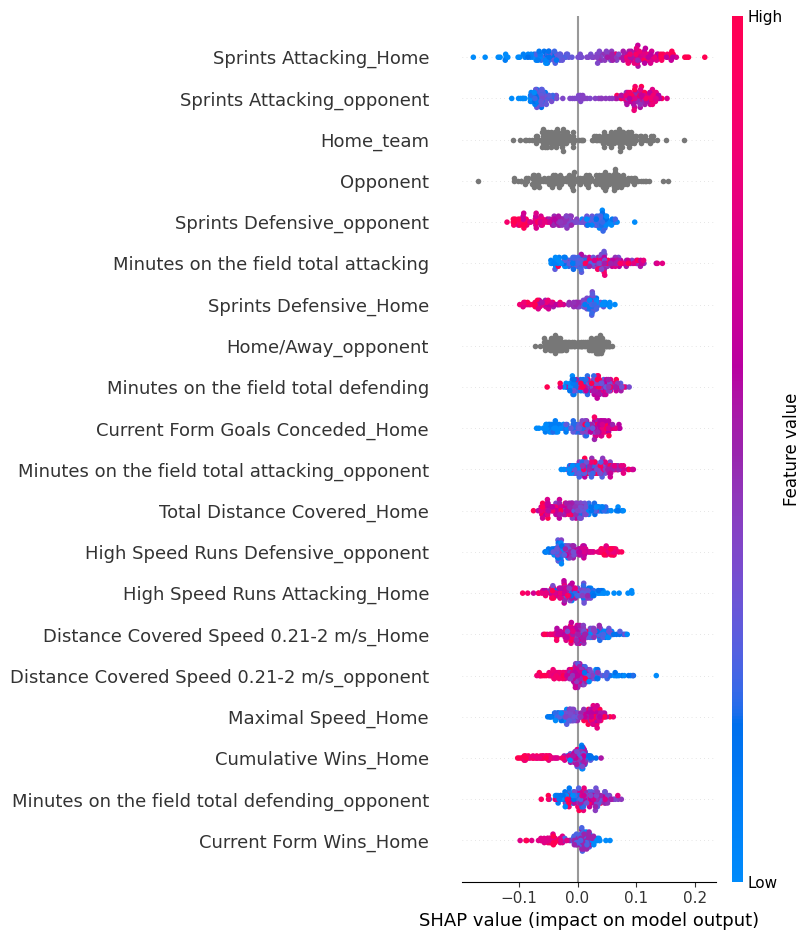

In [267]:
import shap

# Calcolo dei valori SHAP (assuming best_model is your trained model)
explainer_shap = shap.TreeExplainer(best_model)
shap_values = explainer_shap(X_test)[:, :, 0]
expected_value = explainer_shap.expected_value  # Expected value of model predictions

# Extract feature names directly from X_test (assuming columns represent features)
feature_names = X_test.columns.tolist()

# Genera il plot SHAP summary
shap.summary_plot(shap_values, X_test, title="SHAP summary plot Lose", feature_names=feature_names)



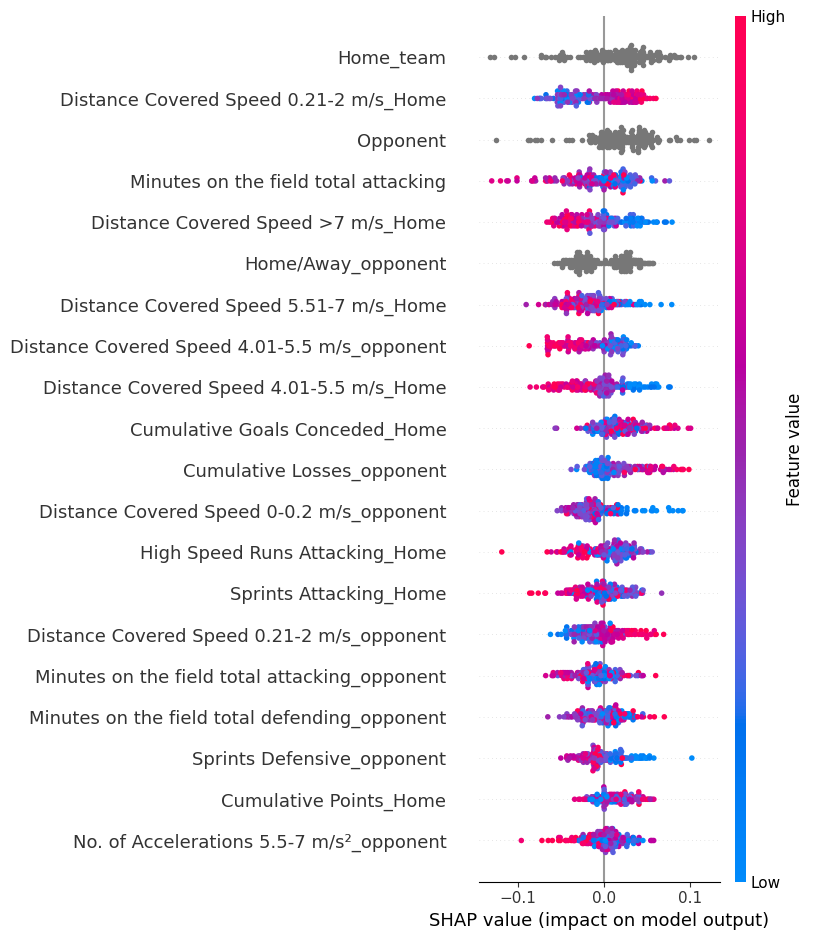

In [268]:
explainer_shap = shap.TreeExplainer(best_model)
shap_values = explainer_shap(X_test)[:, :, 1]
expected_value = explainer_shap.expected_value  # Expected value of model predictions

# Extract feature names directly from X_test (assuming columns represent features)
feature_names = X_test.columns.tolist()

# Genera il plot SHAP summary
shap.summary_plot(shap_values, X_test, title="SHAP summary plot", feature_names=feature_names)

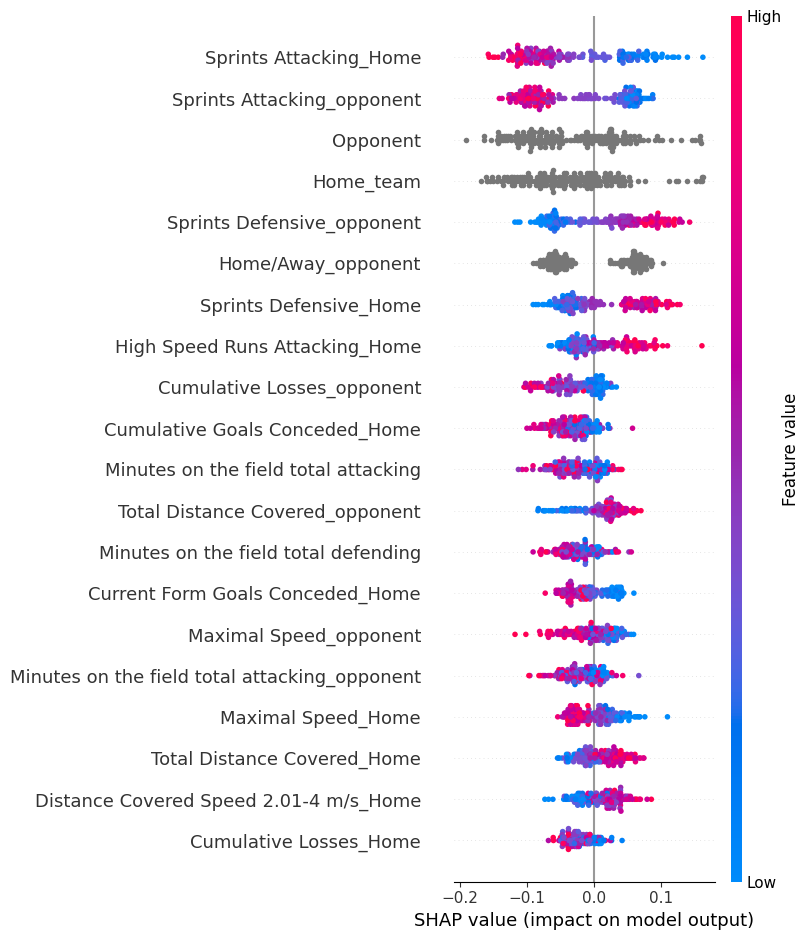

In [269]:
explainer_shap = shap.TreeExplainer(best_model)
shap_values = explainer_shap(X_test)[:, :, 2]
expected_value = explainer_shap.expected_value  # Expected value of model predictions

# Extract feature names directly from X_test (assuming columns represent features)
feature_names = X_test.columns.tolist()

# Genera il plot SHAP summary
shap.summary_plot(shap_values, X_test, title="SHAP summary plot", feature_names=feature_names)

In [270]:
shap_values

.values =
array([[ 0.13883788,  0.00836126, -0.00056319, ...,  0.00344383,
        -0.01251726,  0.0019937 ],
       [ 0.15830441, -0.01106285, -0.02542181, ..., -0.01936159,
         0.00234997,  0.00808733],
       [ 0.1611066 ,  0.00987303, -0.00441566, ..., -0.01466749,
        -0.02503035, -0.002651  ],
       ...,
       [-0.00246597,  0.03755364,  0.00079405, ..., -0.07288344,
        -0.03228213,  0.00676375],
       [-0.09788355,  0.01111705,  0.01435499, ..., -0.0302023 ,
        -0.03351286, -0.04064188],
       [-0.04667615,  0.05998289,  0.01548541, ...,  0.00646581,
        -0.0455077 ,  0.0175048 ]])

.base_values =
array([0.17131163, 0.17131163, 0.17131163, 0.17131163, 0.17131163,
       0.17131163, 0.17131163, 0.17131163, 0.17131163, 0.17131163,
       0.17131163, 0.17131163, 0.17131163, 0.17131163, 0.17131163,
       0.17131163, 0.17131163, 0.17131163, 0.17131163, 0.17131163,
       0.17131163, 0.17131163, 0.17131163, 0.17131163, 0.17131163,
       0.17131163, 0.17131

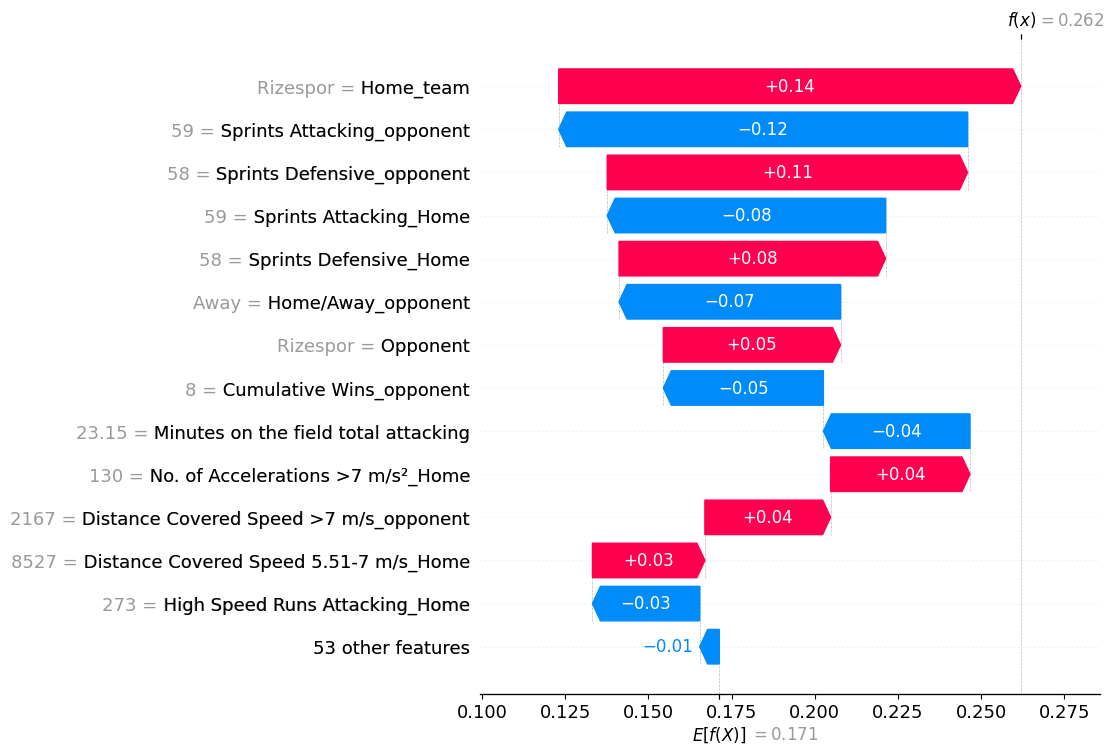

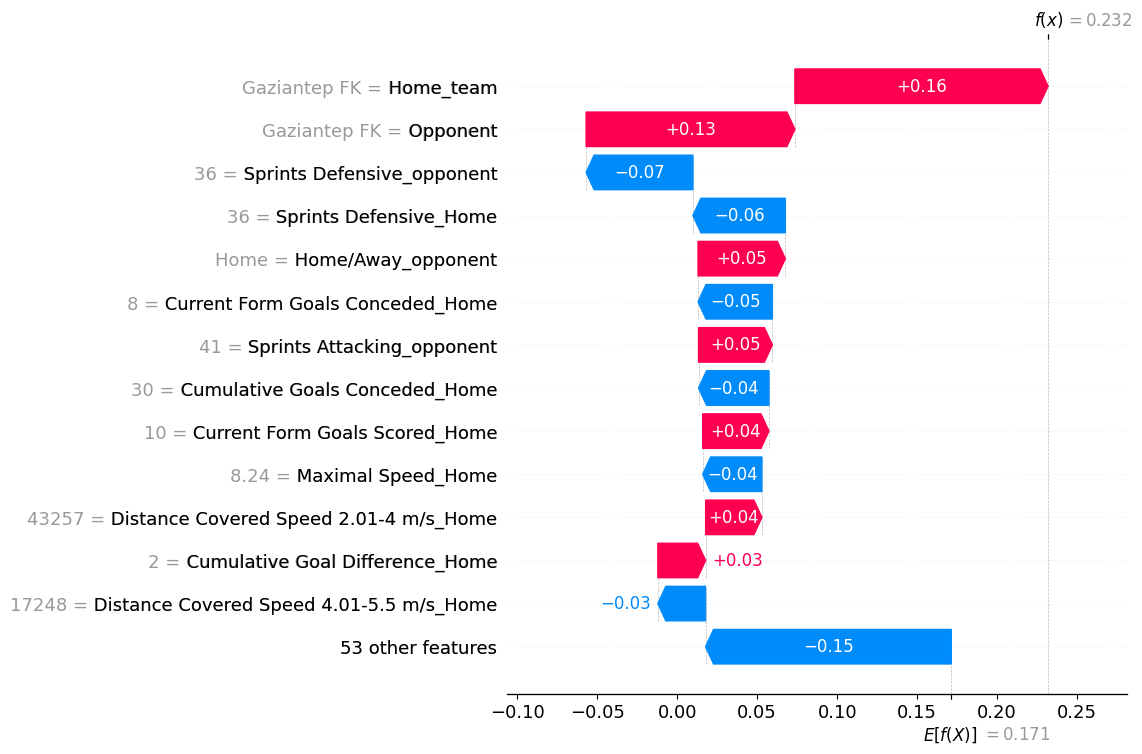

In [271]:
shap.plots.waterfall(shap_values[0], max_display=14)
shap.plots.waterfall(shap_values[1], max_display=14)

In [ ]:
XX = data_total[data_total['season'].isin([2023])]
XX = XX.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)
XX['Match Date'] = pd.to_datetime(X['Match Date'], format='%d.%m.%y')
XX['Result_Home'] = X['Result_Home'].map({'Lose': 0, 'Tie': 1, 'Win': 2})
train_data = X[X['Match Date'] < '2022-10-20'] # 20 Octpber 2022 (10 games)
test_data = X[X['Match Date'] >= '2022-10-20'] # 4 to 6 games
y_train = train_data['Result_Home']
y_test = test_data['Result_Home']

columns_to_remove = ['Result_Home', 'Match Date'] 
X_train = train_data.drop(columns=columns_to_remove)
X_test = test_data.drop(columns=columns_to_remove)